In [1]:
from os import path
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import seaborn as sns
from tqdm import tqdm

from allen_v1dd.client import OPhysClient
from allen_v1dd.stimulus_analysis import StimulusAnalysis, DriftingGratings
import allen_v1dd.stimulus_analysis.analysis_tools as at

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Base directory to save figures
FIG_DIR = r"/Users/chase/Desktop/MindScope/Documents/v1dd-chase/analysis_presentations/2022-10-06-group_meeting/figures"

In [2]:
# base_folder = r"\\allen\programs\mindscope\workgroups\surround\v1dd_in_vivo_new_segmentation\data"
# base_folder = "/Volumes/programs/mindscope/workgroups/surround/v1dd_in_vivo_new_segmentation/data"
# base_folder = "/Volumes/AllenDrive/v1dd/data" # Chase's external hard drive
base_folder = "/Users/chase/Desktop/test_v1dd_data"
client = OPhysClient(base_folder)

In [3]:
metrics = pd.read_csv("/Users/chase/Desktop/MindScope/allen_v1dd/data_frames/v1dd_metrics.csv", index_col=0, low_memory=False)

# Only consider valid metrics
print(f"{np.count_nonzero(metrics.is_valid)}/{len(metrics)} ({np.mean(metrics.is_valid)*100:.1f}%) ROIs are valid")
metrics = metrics[metrics.is_valid & (metrics.mouse == 409828) & (metrics.column == 1)]

metrics.head()

9714/52826 (18.4%) ROIs are valid


mouse  column volume  plane  roi  is_valid  \
M409828_11_1_89  409828       1      1      1   89      True   
M409828_11_2_0   409828       1      1      2    0      True   
M409828_11_2_1   409828       1      1      2    1      True   
M409828_11_2_2   409828       1      1      2    2      True   
M409828_11_2_4   409828       1      1      2    4      True   

                 is_ignored_duplicate  has_duplicate  n_duplicates  \
M409828_11_1_89                 False          False             0   
M409828_11_2_0                  False           True             2   
M409828_11_2_1                  False           True             2   
M409828_11_2_2                  False          False             0   
M409828_11_2_4                  False          False             0   

                                 duplicate_rois  ...  \
M409828_11_1_89                             NaN  ...   
M409828_11_2_0   M409828_11_2_0, M409828_11_3_2  ...   
M409828_11_2_1   M409828_11_2_1, M409828_11_3_0  ...   
M409828_11_2_2                              NaN  ...   
M409828_11_2_4                              NaN  ...   

                 dgw_null_dist_single_std  dgw_resp_pref_dgf  \
M409828_11_1_89                  0.000474           0.000769   
M409828_11_2_0                   0.000662           0.000427   
M409828_11_2_1                   0.000566           0.002216   
M409828_11_2_2                   0.000624           0.000372   
M409828_11_2_4                   0.000397           0.000239   

                 dgf_resp_pref_dgw       ssi      ffsi  ssi_pref_both  \
M409828_11_1_89           0.000635  0.253797  0.404846       0.026889   
M409828_11_2_0            0.000973 -0.076642 -0.166008      -0.079119   
M409828_11_2_1            0.009515 -0.036947 -0.076728      -0.147012   
M409828_11_2_2            0.000386  0.534480  0.696627      -0.015980   
M409828_11_2_4            0.000707 -0.028743 -0.059188      -0.275735   

                 ssi_orth                                      ffsi_all_dirs  \
M409828_11_1_89 -0.140282  [0.4048456362936549, 0.2705844716692601, -0.05...   
M409828_11_2_0   0.064824  [-0.166007564802395, 0.06613494460612107, -0.3...   
M409828_11_2_1   0.039637  [-4.362143088448435, -0.07672845084378654, -0....   
M409828_11_2_2  -0.200084  [-0.08522030840585948, 0.6966266406967715, 0.3...   
M409828_11_2_4  -0.347395  [-1.08211590351918, 0.2385055718687459, -0.067...   

                 spontaneous_event_mean  spontaneous_event_std  
M409828_11_1_89                0.000287               0.001903  
M409828_11_2_0                 0.000346               0.002629  
M409828_11_2_1                 0.000341               0.002262  
M409828_11_2_2                 0.000341               0.002412  
M409828_11_2_4                 0.000234               0.001601  

[5 rows x 100 columns]

In [5]:
# Insert new metrics columns for analysis
def f_depth_chunk(row):
    depth_chunk = int(np.floor((row.depth - 50) / 48)) # 50 is shallowest depth; 48 is size of chunk
    if depth_chunk > 10:
        depth_chunk = 10 # deeper chunks to go 10
    return depth_chunk

metrics["depth_chunk"] = metrics.apply(f_depth_chunk, axis=1)
metrics["vol_plane"] = metrics.apply(lambda row: f"{row.volume}-{row.plane}", axis=1)
print("depth_chunk value counts:")
metrics["depth_chunk"].value_counts().sort_index()

depth_chunk value counts:


0       36
1      551
2      985
3     1081
4     1362
5     1346
6     1307
7      910
8      623
9      589
10     924
Name: depth_chunk, dtype: int64

In [6]:
metrics.columns

Index(['mouse', 'column', 'volume', 'plane', 'roi', 'is_valid',
       'is_ignored_duplicate', 'has_duplicate', 'n_duplicates',
       'duplicate_rois',
       ...
       'dgf_resp_pref_dgw', 'ssi', 'ffsi', 'ssi_pref_both', 'ssi_orth',
       'ffsi_all_dirs', 'spontaneous_event_mean', 'spontaneous_event_std',
       'depth_chunk', 'vol_plane'],
      dtype='object', length=102)

In [7]:
np.mean(metrics.dgw_chisq_response_p < 0.05), np.mean(metrics.dgf_chisq_response_p < 0.05)

(0.23625694873378628, 0.2976116944616018)

In [8]:
metrics["dgw_is_responsive"] = metrics.dgw_frac_responsive_trials >= 0.5
metrics["dgf_is_responsive"] = metrics.dgf_frac_responsive_trials >= 0.5

n_tot = len(metrics) # same no. ROIs for both dg_full and dg_windowed
n_both = np.logical_and(metrics.dgf_is_responsive, metrics.dgw_is_responsive).value_counts()[True]
n_full = metrics.dgf_is_responsive.value_counts()[True]
n_windowed = metrics.dgw_is_responsive.value_counts()[True]
n_full_only = n_full - n_both
n_windowed_only = n_windowed - n_both
n_either = (metrics.dgf_is_responsive | metrics.dgw_is_responsive).value_counts()[True]
n_neither = np.logical_and(~metrics.dgf_is_responsive, ~metrics.dgw_is_responsive).value_counts()[True]

print(f"{n_full}/{n_tot} ({n_full/n_tot*100:.1f}%) ROIs are responsive to DG-full")
print(f"{n_windowed}/{n_tot} ({n_windowed/n_tot*100:.1f}%) ROIs are responsive to DG-windowed")
print()
print(f"{n_either}/{n_tot} ({n_either/n_tot*100:.1f}%) ROIs are responsive to DG-full OR DG-windowed")
print(f"{n_both}/{n_tot} ({n_both/n_tot*100:.1f}%) ROIs are responsive to BOTH DG-full AND DG-windowed")
print(f"{n_full_only}/{n_tot} ({n_full_only/n_tot*100:.1f}%) ROIs are responsive to ONLY DG-full")
print(f"{n_windowed_only}/{n_tot} ({n_windowed_only/n_tot*100:.1f}%) ROIs are responsive to ONLY DG-windowed")
print(f"{n_neither}/{n_tot} ({n_neither/n_tot*100:.1f}%) ROIs are responsive to NEITHER")

2312/9714 (23.8%) ROIs are responsive to DG-full
2092/9714 (21.5%) ROIs are responsive to DG-windowed

3569/9714 (36.7%) ROIs are responsive to DG-full OR DG-windowed
835/9714 (8.6%) ROIs are responsive to BOTH DG-full AND DG-windowed
1477/9714 (15.2%) ROIs are responsive to ONLY DG-full
1257/9714 (12.9%) ROIs are responsive to ONLY DG-windowed
6145/9714 (63.3%) ROIs are responsive to NEITHER


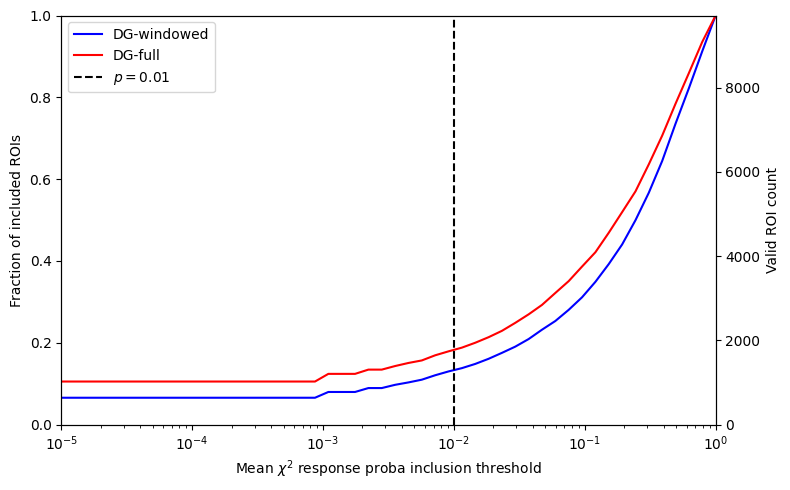

In [9]:
x = np.logspace(-5, 0, 50)
yf = [np.mean(metrics.dgf_chisq_response_p < thresh) for thresh in x]
yw = [np.mean(metrics.dgw_chisq_response_p < thresh) for thresh in x]

fig, ax = plt.subplots(figsize=(8, 5), facecolor="white")
ax.plot(x, yw, color="b", label="DG-windowed")
ax.plot(x, yf, color="r", label="DG-full")
ax.set_xlabel(r"Mean $\chi^2$ response proba inclusion threshold")
ax.set_ylabel("Fraction of included ROIs")
ax.set_xlim(x.min(), x.max())
ax.set_ylim(0, 1)
ax.axvline(x=0.01, color="black", linestyle="dashed", label="$p=0.01$")
ax.set_xscale("log")
ax2 = ax.twinx()
ax2.set_ylim(0, len(metrics))
ax2.set_ylabel("Valid ROI count")
ax.legend()
fig.tight_layout()
# fig.savefig(f"{FIG_DIR}/inclusion_frac_pref_chisq_resp_proba.png")

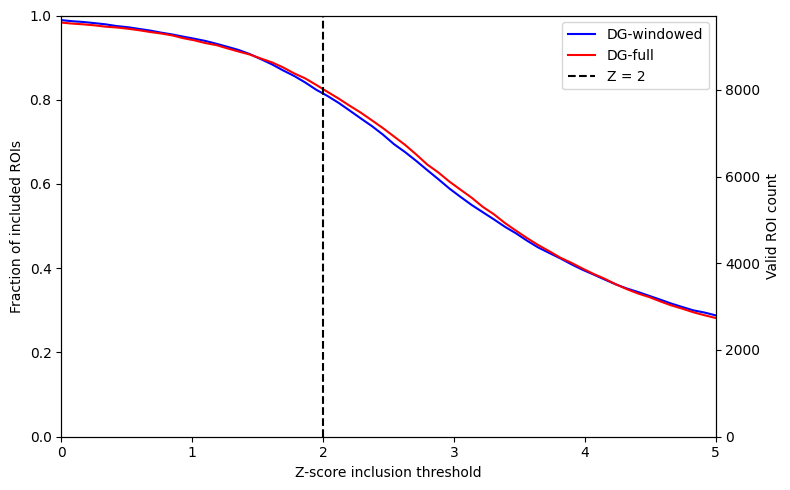

In [10]:
x = np.linspace(0, 5, 60)
yf = [np.mean(metrics.dgf_z_score >= thresh) for thresh in x]
yw = [np.mean(metrics.dgw_z_score >= thresh) for thresh in x]

fig, ax = plt.subplots(figsize=(8, 5), facecolor="white")
ax.plot(x, yw, color="b", label="DG-windowed")
ax.plot(x, yf, color="r", label="DG-full")
ax.axvline(x=2, color="black", linestyle="dashed", label="Z = 2")
ax.set_xlabel("Z-score inclusion threshold")
ax.set_ylabel("Fraction of included ROIs")
ax.set_xlim(x.min(), x.max())
ax.set_ylim(0, 1)
ax2 = ax.twinx()
ax2.set_ylim(0, len(metrics))
ax2.set_ylabel("Valid ROI count")
ax.legend()
fig.tight_layout()
# fig.savefig(f"{FIG_DIR}/inclusion_frac_z_score.png")

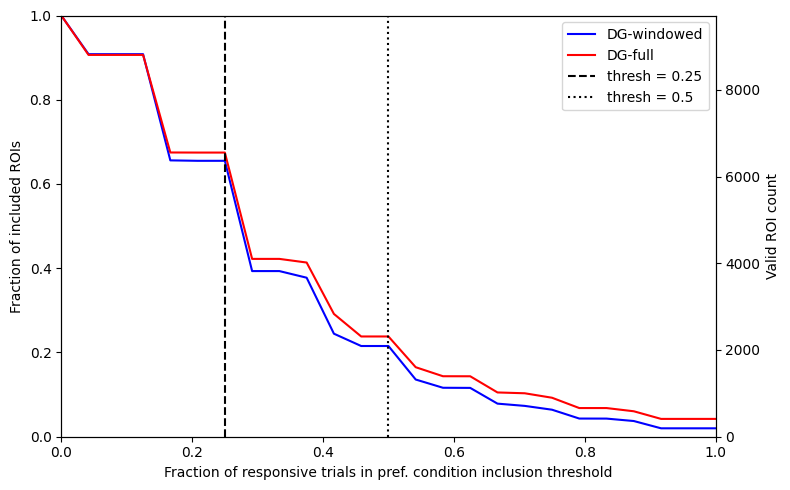

In [11]:
x = np.linspace(0, 1, 25)
yf = [np.mean(metrics.dgf_frac_responsive_trials >= thresh) for thresh in x]
yw = [np.mean(metrics.dgw_frac_responsive_trials >= thresh) for thresh in x]

fig, ax = plt.subplots(figsize=(8, 5), facecolor="white")
ax.plot(x, yw, color="b", label="DG-windowed")
ax.plot(x, yf, color="r", label="DG-full")
ax.set_xlabel("Fraction of responsive trials in pref. condition inclusion threshold")
ax.set_ylabel("Fraction of included ROIs")
ax.set_xlim(x.min(), x.max())
ax.set_ylim(0, 1)
ax.axvline(x=0.25, color="black", linestyle="dashed", label="thresh = 0.25")
ax.axvline(x=0.5, color="black", linestyle="dotted", label="thresh = 0.5")
ax2 = ax.twinx()
ax2.set_ylim(0, len(metrics))
ax2.set_ylabel("Valid ROI count")
ax.legend()
fig.tight_layout()
# fig.savefig(f"{FIG_DIR}/inclusion_frac_vis_coding.png")

(-1.0395121084482324,
 1.0545167851014619,
 -1.018490877196703,
 1.096118613199843)

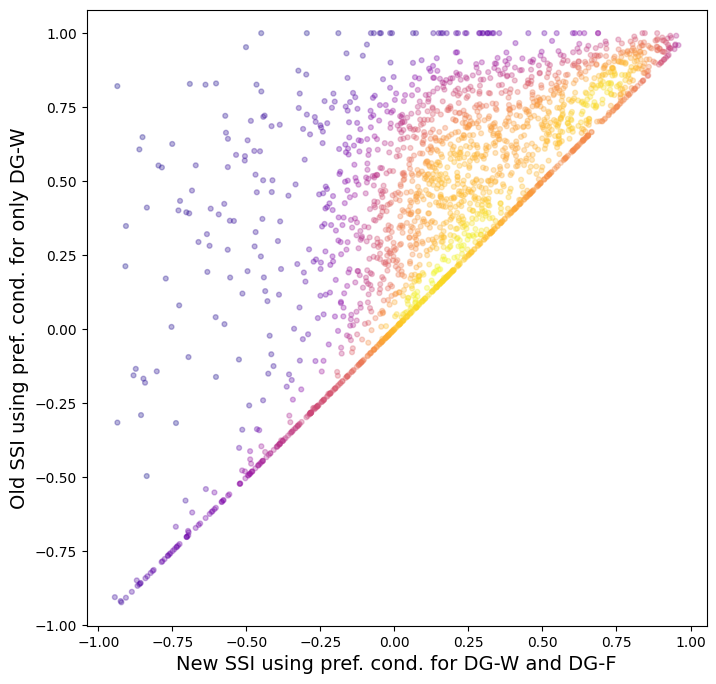

In [12]:
inclusion = metrics.dgw_is_responsive
at.density_scatter(
    metrics.ssi_pref_both[inclusion], metrics.ssi[inclusion],
    figsize=(8, 8),
    xlabel="New SSI using pref. cond. for DG-W and DG-F",
    ylabel="Old SSI using pref. cond. for only DG-W",
    alpha=0.3
).axis("equal")

(0.027712383914264366,
 1.046299410289797,
 -0.013534282834823753,
 1.0482635372778488)

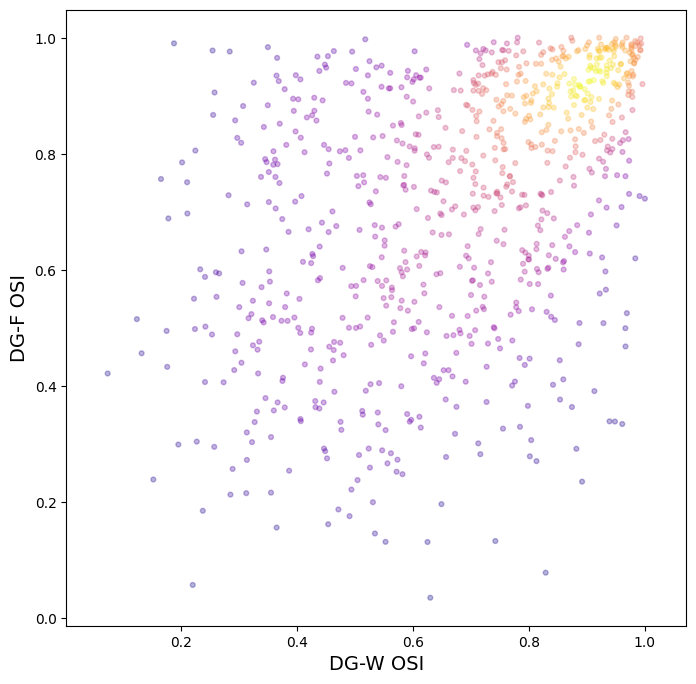

In [13]:
inclusion = metrics.dgw_is_responsive & metrics.dgf_is_responsive
at.density_scatter(
    metrics.dgw_osi[inclusion], metrics.dgf_osi[inclusion],
    figsize=(8, 8),
    xlabel="DG-W OSI",
    ylabel="DG-F OSI",
    alpha=0.3
).axis("equal")

(-0.013268530309770467,
 0.932473257240912,
 -0.03463731399491392,
 1.0100407300414473)

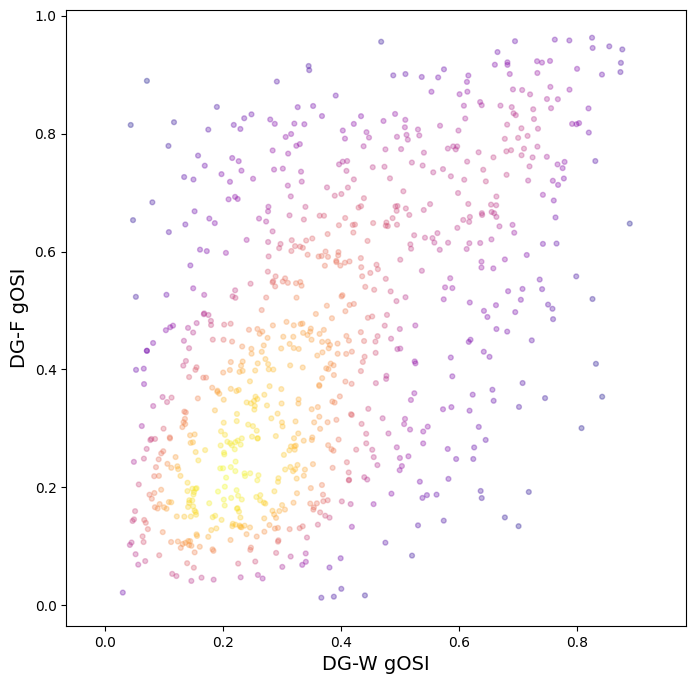

In [14]:
inclusion = metrics.dgw_is_responsive & metrics.dgf_is_responsive
at.density_scatter(
    metrics.dgw_gosi[inclusion], metrics.dgf_gosi[inclusion],
    figsize=(8, 8),
    xlabel="DG-W gOSI",
    ylabel="DG-F gOSI",
    alpha=0.3
).axis("equal")

(0.0, 0.02)

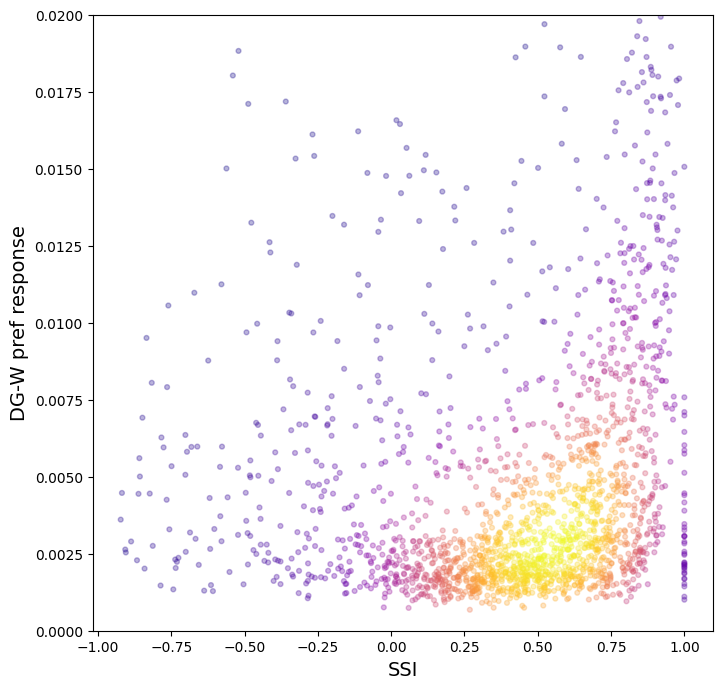

In [15]:
inclusion = metrics.dgw_is_responsive# & metrics.dgf_is_responsive
inclusion = metrics.dgw_frac_responsive_trials >= 0.5
# inclusion = metrics.dgw_chisq_response_p <= 0.01
ax = at.density_scatter(
    metrics.ssi[inclusion], metrics.dgw_pref_response[inclusion],
    figsize=(8, 8),
    xlabel="SSI",
    ylabel="DG-W pref response",
    alpha=0.3
)
ax.set_ylim(0, 0.02)
# ax.axis("equal")
# ax.set_xlim(-1, 1)
# ax.set_ylim(-1, 1)

In [16]:
metrics.columns

Index(['mouse', 'column', 'volume', 'plane', 'roi', 'is_valid',
       'is_ignored_duplicate', 'has_duplicate', 'n_duplicates',
       'duplicate_rois',
       ...
       'ffsi', 'ssi_pref_both', 'ssi_orth', 'ffsi_all_dirs',
       'spontaneous_event_mean', 'spontaneous_event_std', 'depth_chunk',
       'vol_plane', 'dgw_is_responsive', 'dgf_is_responsive'],
      dtype='object', length=104)

In [17]:
m = np.maximum(metrics.dgw_pref_response.values, metrics.dgf_resp_pref_dgw.values)
metrics["ss_nassi_2013"] = (m - metrics.dgf_resp_pref_dgw.values) / m

(array([  15.,   29.,   40.,   48.,   52.,   80.,  115.,  165.,  330.,
         529.,  804., 1081., 1211., 1200., 1082.,  907.,  954.,  554.,
         518.]),
 array([-1.        , -0.89473684, -0.78947368, -0.68421053, -0.57894737,
        -0.47368421, -0.36842105, -0.26315789, -0.15789474, -0.05263158,
         0.05263158,  0.15789474,  0.26315789,  0.36842105,  0.47368421,
         0.57894737,  0.68421053,  0.78947368,  0.89473684,  1.        ]),
 <BarContainer object of 19 artists>)

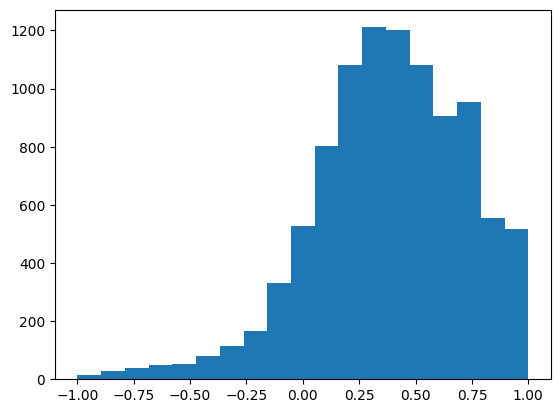

In [18]:
inclusion = metrics.dgw_frac_responsive_trials >= 0.5
plt.hist(metrics.ssi, bins=np.linspace(-1, 1, 20))

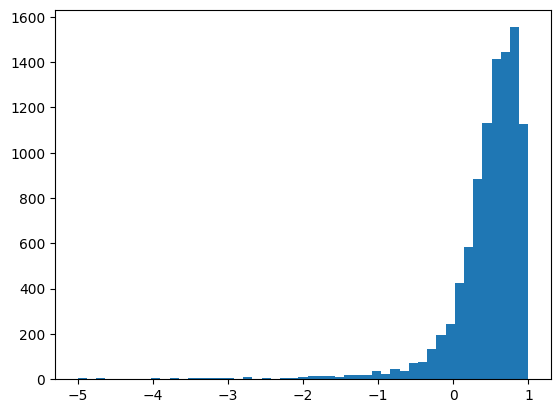

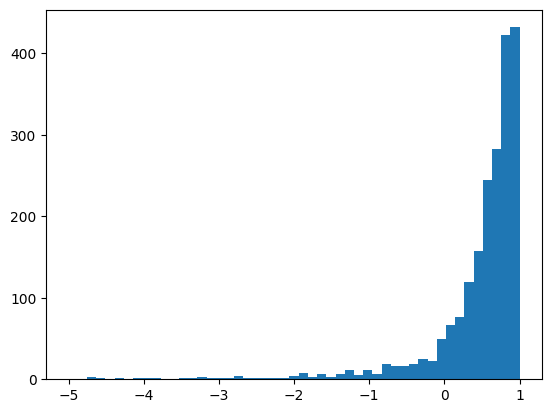

In [19]:
inclusion = metrics.dgw_frac_responsive_trials >= 0.5
plt.figure()
plt.hist(metrics.ffsi, bins=np.linspace(-5, 1, 50))
plt.figure()
plt.hist(metrics.ffsi[inclusion], bins=np.linspace(-5, 1, 50))
None

(array([335.,  52.,  83.,  97., 133., 176., 233., 273., 358., 352.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

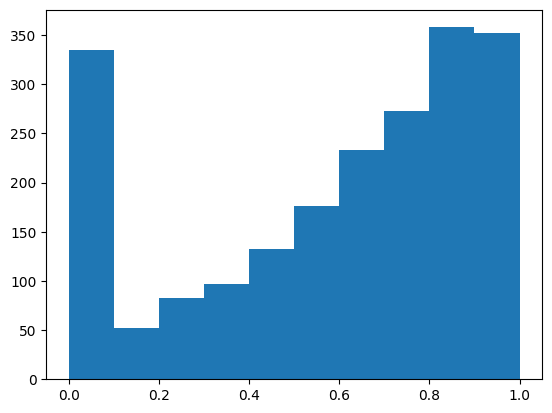

In [20]:
plt.hist(metrics.ss_nassi_2013[metrics.dgw_is_responsive])

In [21]:
metrics["si_reza"] = metrics.dgw_pref_response / metrics.dgf_resp_pref_dgw

In [22]:
metrics.dgw_pref_response

M409828_11_1_89    0.001066
M409828_11_2_0     0.000834
M409828_11_2_1     0.008837
M409828_11_2_2     0.001273
M409828_11_2_4     0.000668
                     ...   
M409828_1f_1_67    0.002271
M409828_1f_1_69    0.006499
M409828_1f_1_70    0.002041
M409828_1f_1_74    0.001925
M409828_1f_1_90    0.002539
Name: dgw_pref_response, Length: 9714, dtype: float64

In [23]:
df_si[df_si.depth == 306].si_reza

NameError: name 'df_si' is not defined

(0.0, 15.0)

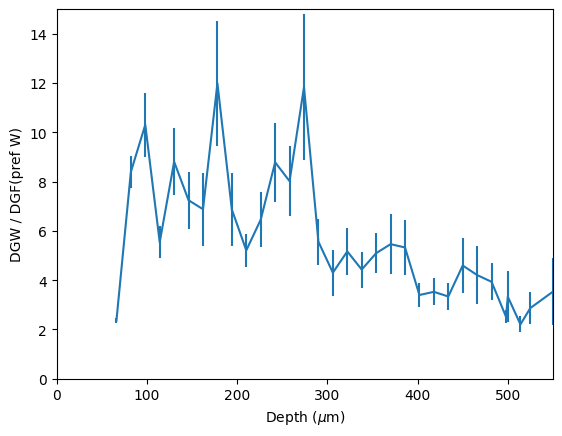

In [24]:
df_si = metrics[(metrics.dgw_frac_responsive_trials >= 0.45) & (np.isfinite(metrics.si_reza))]
df = df_si.groupby("depth")["si_reza"].mean()
depths = df.index
mean_ffsi = df.values
std_ffsi = df_si.groupby("depth")["si_reza"].std().values
n_rois_at_depth = df_si["depth"].value_counts().values

plt.errorbar(depths, mean_ffsi, yerr=std_ffsi/np.sqrt(n_rois_at_depth))
plt.xlabel("Depth ($\mu$m)")
plt.ylabel("DGW / DGF(pref W)")
plt.xlim(0, 550)
plt.ylim(0, 15)

In [26]:
(metrics.dgf_frac_responsive_trials >= 0.5).sum()

2312

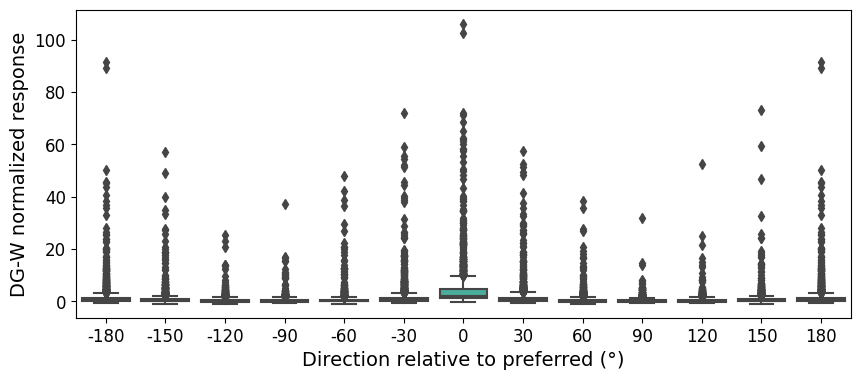

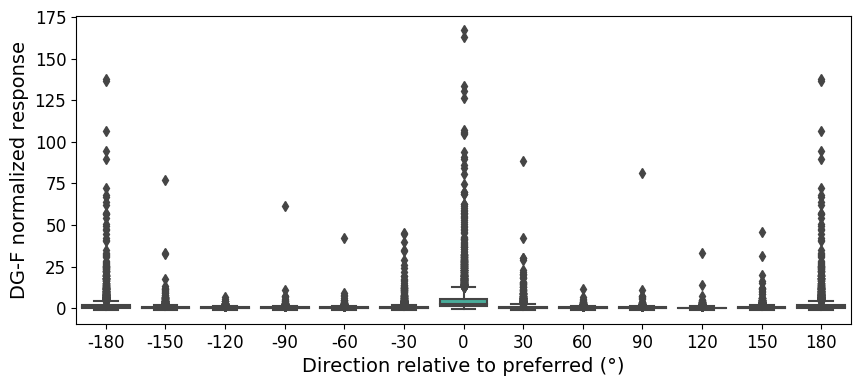

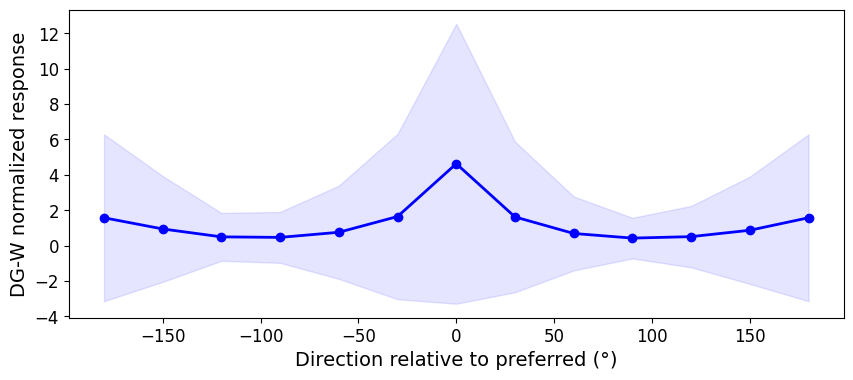

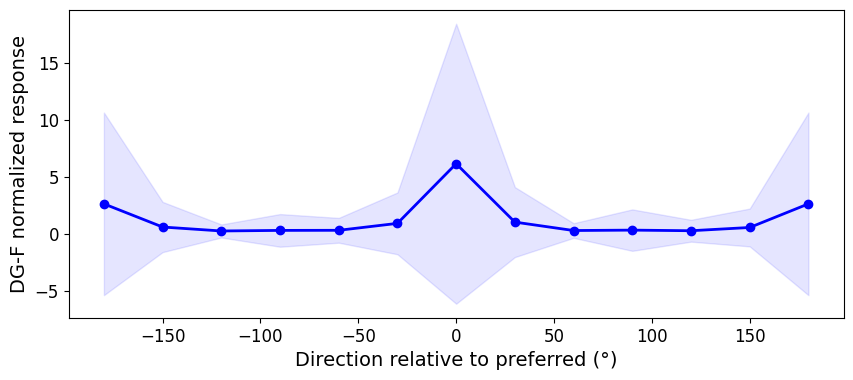

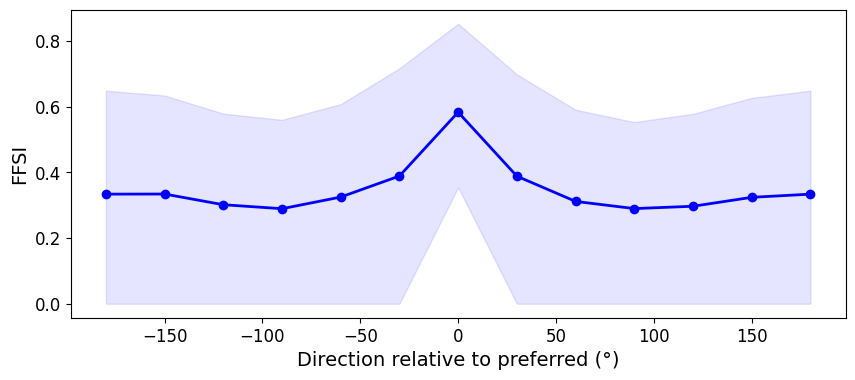

In [27]:
relative_dir_list = np.array([-180, -150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150, 180])
relative_dir_idx = np.arange(13) - 6
ffsi_by_rel_dir = [[] for _ in relative_dir_idx]
dgw_norm_resp_by_rel_dir = [[] for _ in relative_dir_idx]
dgf_norm_resp_by_rel_dir = [[] for _ in relative_dir_idx]

for i, row in metrics.iterrows():
    if row["dgw_frac_responsive_trials"] >= 0.5:
        pref_dir_idx = int(row["dgw_pref_dir_idx"])
        ffsi_all_dirs = eval(row["ffsi_all_dirs"])
        dgw_norm_dir_responses = eval(row["dgw_norm_dir_responses"])

        for j, dir_offset in enumerate(relative_dir_idx):
            dir_i = (pref_dir_idx+dir_offset) % 12
            ffsi = ffsi_all_dirs[dir_i]
            ffsi = max(0, ffsi)
            ffsi_by_rel_dir[j].append(ffsi)
            dgw_norm_resp_by_rel_dir[j].append(dgw_norm_dir_responses[dir_i])

    if row["dgf_frac_responsive_trials"] >= 0.5:
        pref_dir_idx = int(row["dgf_pref_dir_idx"])
        dgf_norm_dir_responses = eval(row["dgf_norm_dir_responses"])

        for j, dir_offset in enumerate(relative_dir_idx):
            dir_i = (pref_dir_idx+dir_offset) % 12
            dgf_norm_resp_by_rel_dir[j].append(dgf_norm_dir_responses[dir_i])

# Norm resp. box plot
fig, ax = plt.subplots(figsize=(10, 4), facecolor="white")
x, y = [], []
for dir, arr in zip(relative_dir_list, dgw_norm_resp_by_rel_dir):
    x.extend([dir] * len(arr))
    y.extend(arr)
sns.boxplot(x=x, y=y, ax=ax)
ax.tick_params(labelsize=12)
ax.set_xlabel("Direction relative to preferred (°)", fontsize=14)
ax.set_ylabel("DG-W normalized response", fontsize=14)

fig, ax = plt.subplots(figsize=(10, 4), facecolor="white")
x, y = [], []
for dir, arr in zip(relative_dir_list, dgf_norm_resp_by_rel_dir):
    x.extend([dir] * len(arr))
    y.extend(arr)
sns.boxplot(x=x, y=y, ax=ax)
ax.tick_params(labelsize=12)
ax.set_xlabel("Direction relative to preferred (°)", fontsize=14)
ax.set_ylabel("DG-F normalized response", fontsize=14)
# ax.set_ylim(-5, 50)

# Line plot of means ± error
y_means = np.array([np.mean(arr) for arr in dgw_norm_resp_by_rel_dir])
y_err = np.array([np.std(arr) for arr in dgw_norm_resp_by_rel_dir])
fig, ax = plt.subplots(figsize=(10, 4), facecolor="white")
ax.tick_params(labelsize=12)
ax.set_xlabel("Direction relative to preferred (°)", fontsize=14)
ax.set_ylabel("DG-W normalized response", fontsize=14)
# plt.errorbar(relative_dir_list, y_means, yerr=y_err)
ax.plot(relative_dir_list, y_means, color="blue", linewidth=2, marker=".", markersize=12)
ax.fill_between(relative_dir_list, y_means-y_err, y_means+y_err, color="blue", alpha=0.1)

y_means = np.array([np.mean(arr) for arr in dgf_norm_resp_by_rel_dir])
y_err = np.array([np.std(arr) for arr in dgf_norm_resp_by_rel_dir])
fig, ax = plt.subplots(figsize=(10, 4), facecolor="white")
ax.tick_params(labelsize=12)
ax.set_xlabel("Direction relative to preferred (°)", fontsize=14)
ax.set_ylabel("DG-F normalized response", fontsize=14)
# plt.errorbar(relative_dir_list, y_means, yerr=y_err)
ax.plot(relative_dir_list, y_means, color="blue", linewidth=2, marker=".", markersize=12)
ax.fill_between(relative_dir_list, y_means-y_err, y_means+y_err, color="blue", alpha=0.1)

# FFSI line plot
y_ffsi_means = np.array([np.mean(arr) for arr in ffsi_by_rel_dir])
y_ffsi_err = np.array([np.std(arr) for arr in ffsi_by_rel_dir])
y_ffsi_err_low = [np.quantile(arr, 0.25) for arr in ffsi_by_rel_dir]
y_ffsi_err_high = [np.quantile(arr, 0.75) for arr in ffsi_by_rel_dir]
fig, ax = plt.subplots(figsize=(10, 4), facecolor="white")
ax.tick_params(labelsize=12)
ax.set_xlabel("Direction relative to preferred (°)", fontsize=14)
ax.set_ylabel("FFSI", fontsize=14)
# plt.errorbar(relative_dir_list, y_means, yerr=y_err)
ax.plot(relative_dir_list, y_ffsi_means, color="blue", linewidth=2, marker=".", markersize=12)
# ax.fill_between(relative_dir_list, y_ffsi_means-y_ffsi_err, y_ffsi_means+y_ffsi_err, color="blue", alpha=0.1)
ax.fill_between(relative_dir_list, y_ffsi_err_low, y_ffsi_err_high, color="blue", alpha=0.1)

In [ ]:
norm_resp_by_rel_dir = [[] for _ in relative_dir_idx]

for i, row in metrics.iterrows():
    if row["is_valid"] and row["dgw_frac_responsive_trials"] >= 0.5:
        pref_dir_idx = row["pref_dir_idx"]

        for j, dir_offset in enumerate(relative_dir_idx):
            dir_i = (pref_dir_idx+dir_offset) % len(dir_list)
            ffsi = row["norm_dir_responses"][dir_i]
            ffsi = max(0, ffsi)
            norm_resp_by_rel_dir[j].append(ffsi)

# Box plot
fig, ax = plt.subplots(figsize=(10, 4), facecolor="white")
x, y = [], []
for dir, arr in zip(relative_dir_list, norm_resp_by_rel_dir):
    x.extend([dir] * len(arr))
    y.extend(arr)
sns.boxplot(x=x, y=y, ax=ax)
ax.tick_params(labelsize=12)
ax.set_xlabel("Direction relative to preferred (°)", fontsize=14)
ax.set_ylabel("Normalized response", fontsize=14)
# ax.set_ylim(-5, 50)

# Line plot of means ± error
y_means = np.array([np.mean(arr) for arr in norm_resp_by_rel_dir])
y_err = np.array([np.std(arr) for arr in norm_resp_by_rel_dir])
fig, ax = plt.subplots(figsize=(10, 4), facecolor="white")
ax.tick_params(labelsize=12)
ax.set_xlabel("Direction relative to preferred (°)", fontsize=14)
ax.set_ylabel("Normalized response", fontsize=14)
# plt.errorbar(relative_dir_list, y_means, yerr=y_err)
ax.plot(relative_dir_list, y_means, color="blue", linewidth=2, marker=".", markersize=12)
ax.fill_between(relative_dir_list, y_means-y_err, y_means+y_err, color="blue", alpha=0.1)

(0.03422116616005046,
 1.0459894682780928,
 0.04190456940786635,
 1.0456235919329588)

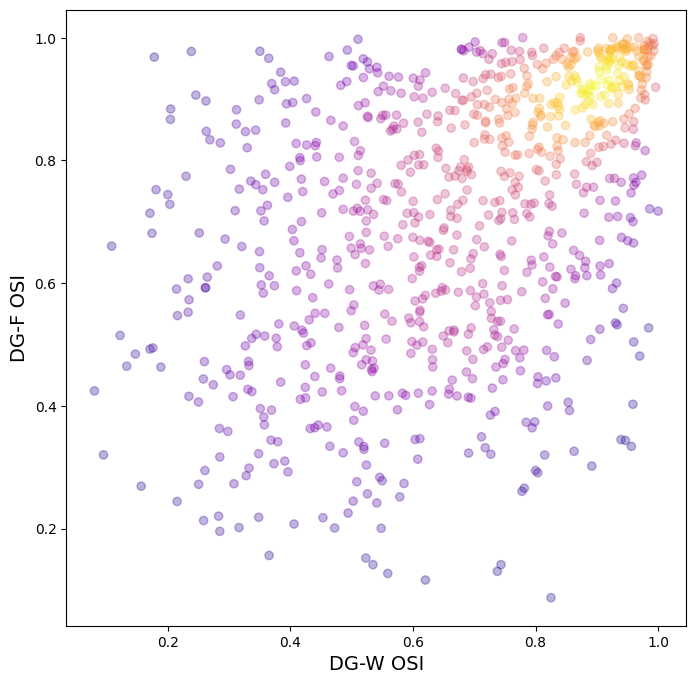

In [48]:
inclusion = metrics.dgw_is_responsive & metrics.dgf_is_responsive
at.density_scatter(
    metrics.dgw_osi[inclusion], metrics.dgf_osi[inclusion],
    # metrics.dgw_osi, metrics.dgf_osi,
    figsize=(8, 8),
    xlabel="DG-W OSI",
    ylabel="DG-F OSI",
    alpha=0.3
).axis("equal")

Text(0.5, 1.0, 'New SSI distribution of responsive-dgw & responsive-dgf')

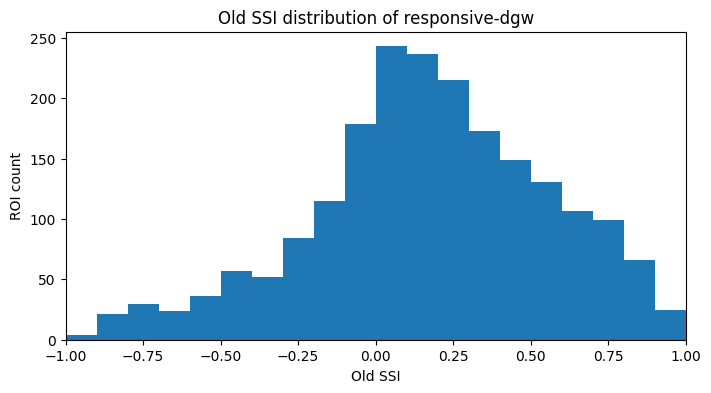

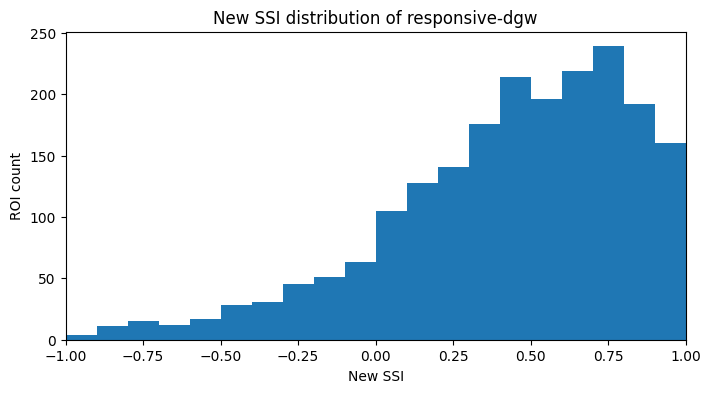

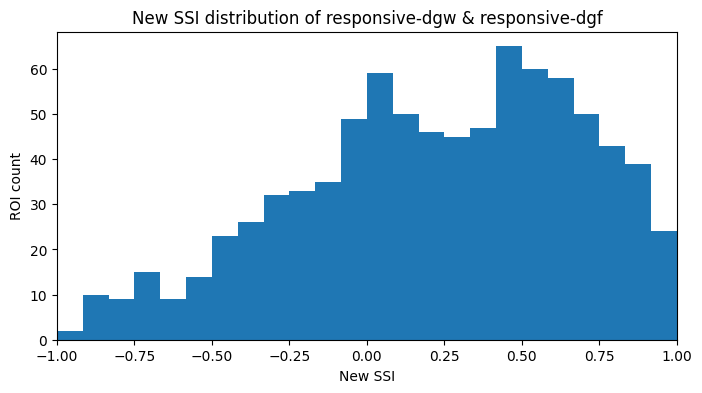

In [28]:
fig, ax = plt.subplots(figsize=(8, 4), facecolor="white")
bins = np.linspace(-1, 1, 21)
ssi = metrics.ssi_pref_both[metrics.dgw_is_responsive]

ax.hist(ssi, bins=bins)
# sns.kdeplot(ssi, ax=ax)
ax.set_xlim(bins.min(), bins.max())
ax.set_xlabel("Old SSI")
ax.set_ylabel("ROI count")
ax.set_title("Old SSI distribution of responsive-dgw")

fig, ax = plt.subplots(figsize=(8, 4), facecolor="white")
bins = np.linspace(-1, 1, 21)
ssi = metrics.ssi[metrics.dgw_is_responsive]

ax.hist(ssi, bins=bins)
# sns.kdeplot(ssi, ax=ax)
ax.set_xlim(bins.min(), bins.max())
ax.set_xlabel("New SSI")
ax.set_ylabel("ROI count")
ax.set_title("New SSI distribution of responsive-dgw")


fig, ax = plt.subplots(figsize=(8, 4), facecolor="white")
bins = np.linspace(-1, 1, 25)
ssi = metrics.ssi[metrics.dgw_is_responsive & metrics.dgf_is_responsive]

ax.hist(ssi, bins=bins)
# sns.kdeplot(ssi, ax=ax)
ax.set_xlim(bins.min(), bins.max())
ax.set_xlabel("New SSI")
ax.set_ylabel("ROI count")
ax.set_title("New SSI distribution of responsive-dgw & responsive-dgf")

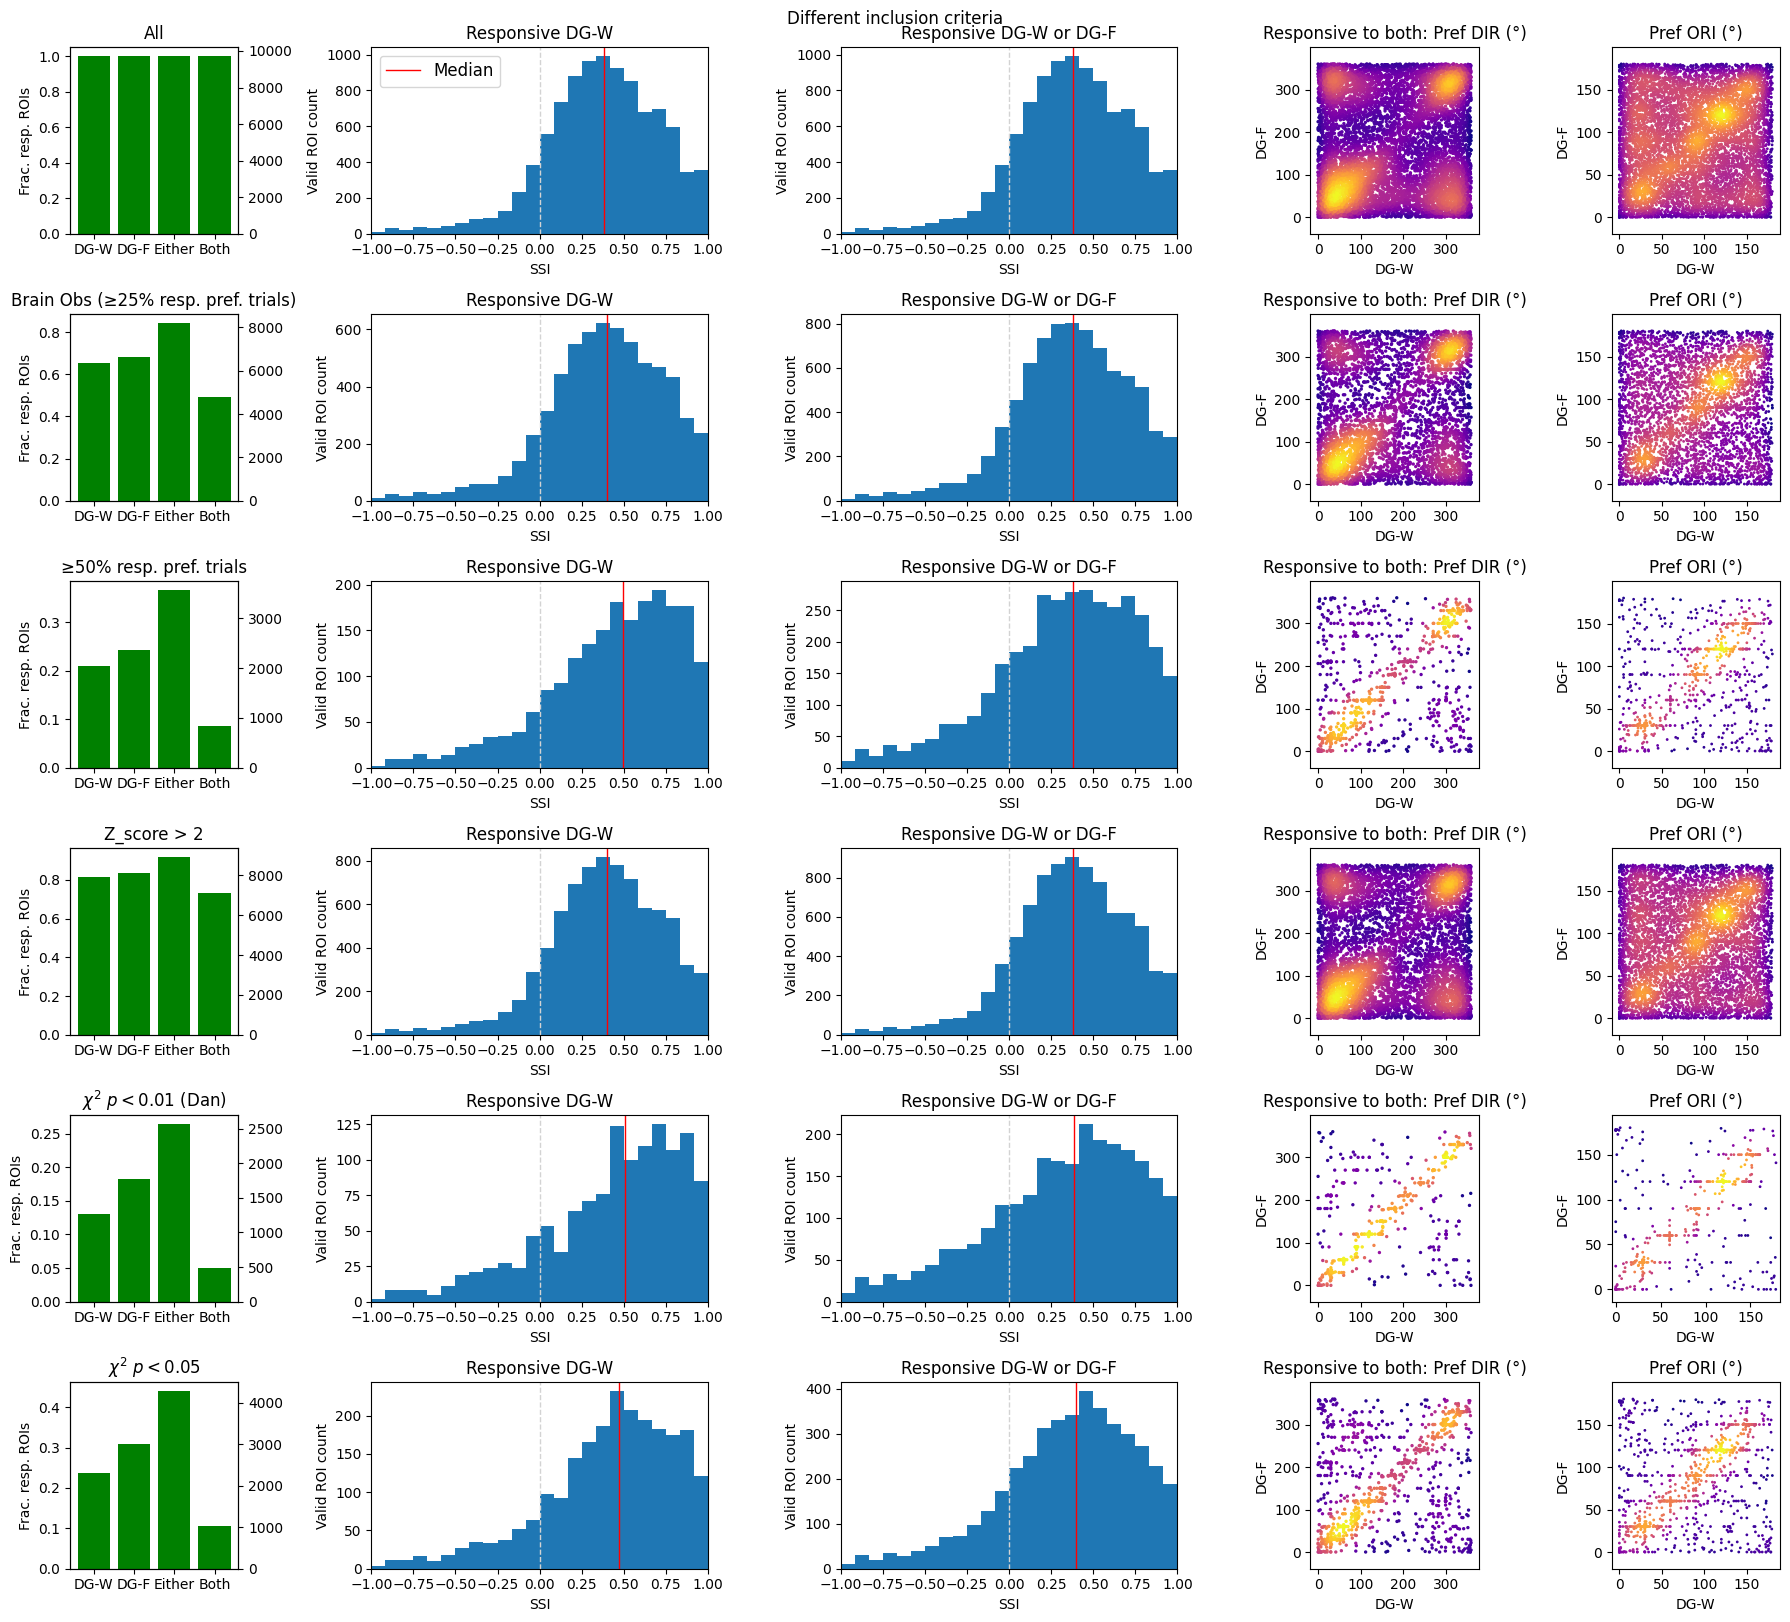

In [35]:
inclusion_criteria = [
    (lambda stim: metrics.index == metrics.index, r"All"),
    (lambda stim: metrics[f"{stim}_frac_responsive_trials"] >= 0.25, r"Brain Obs (≥25% resp. pref. trials)"),
    (lambda stim: metrics[f"{stim}_frac_responsive_trials"] >= 0.5, r"≥50% resp. pref. trials"),
    # (lambda df: df.frac_responsive_trials_naive >= 0.35, r"≥35% resp trials in pref dir"),
    (lambda stim: metrics[f"{stim}_z_score"] > 2, r"Z_score > 2"),
    (lambda stim: metrics[f"{stim}_chisq_response_p"] < 0.01, r"$\chi^2$ $p < 0.01$ (Dan)"),
    (lambda stim: metrics[f"{stim}_chisq_response_p"] < 0.05, r"$\chi^2$ $p < 0.05$"),
    # (lambda df, resp: (df.frac_responsive_trials_naive >= 0.25) & (resp > 1.5e-3), r"Brain Obs & R > 1e-3"),
    # (lambda df: df.z_score_naive > 3, r"Z_score > 3"),
    # (lambda df: df.z_score > 3.5, r"Z_score > 3.5"),
    # (lambda df: df.z_score_naive > 4, r"Z_score > 4"),
    # (lambda df: df.z_score_naive > 5, r"Z_score > 5"),
    # (lambda df: df.z_score_naive > 3, r"Z_score_naive > 3"),
    # (lambda df: df.response_p_naive < 0.05, r"pref_resp_proba < 0.05"),
    # (lambda df: df.response_p_naive < 0.05, r"pref_resp_proba_naive < 0.05"),
    # (lambda df: df.response_p_naive < 0.05/24, r"pref_resp_proba < 0.05/24"),
    # (lambda df: df.response_p_naive == 0, r"pref_resp_proba == 0"),
    # (lambda df: df.z_score > 3, r"Z_score > 3"),
]

fig, ax_rows = plt.subplots(figsize=(18, len(inclusion_criteria)*2.75), nrows=len(inclusion_criteria), ncols=5, gridspec_kw=dict(width_ratios=[1, 2, 2, 1, 1]))
ss_bins = np.linspace(-1, 1, 25)

for i, axs in enumerate(ax_rows):
    inclusion, name = inclusion_criteria[i]
    include_mask = inclusion("dgw")
    mask_full = inclusion("dgf")
    tot = len(metrics)

    ax = axs[0]
    ax.set_title(f"{name}")
    ax.bar(
        x=["DG-W", "DG-F", "Either", "Both"],
        height=[np.mean(include_mask), np.mean(mask_full), np.mean(include_mask | mask_full), np.mean(include_mask & mask_full)],
        color="g")
    ax.set_ylabel("Frac. resp. ROIs")
    # ax.set_ylim(0, 1)
    ax.twinx().set_ylim(0, ax.get_ylim()[1]*tot)
    
    ax = axs[1]
    ax.hist(metrics.ssi[include_mask], bins=ss_bins)
    ax.axvline(x=0, color="lightgray", linestyle="dashed", linewidth=1)
    ax.axvline(x=np.median(metrics.ssi[include_mask]), color="red", linestyle="solid", linewidth=1, label="Median")
    ax.set_xlim(-1, 1)
    ax.set_xlabel("SSI")
    ax.set_ylabel("Valid ROI count")
    ax.set_title("Responsive DG-W")

    if i == 0:
        ax.legend(loc="upper left", fontsize=12)

    ax = axs[2]
    ax.hist(metrics.ssi[include_mask | mask_full], bins=ss_bins)
    ax.axvline(x=0, color="lightgray", linestyle="dashed", linewidth=1)
    ax.axvline(x=np.median(metrics.ssi[include_mask | mask_full]), color="red", linestyle="solid", linewidth=1)
    ax.set_xlim(-1, 1)
    ax.set_xlabel("SSI")
    ax.set_ylabel("Valid ROI count")
    ax.set_title("Responsive DG-W or DG-F")

    ax = axs[3]
    both = include_mask & mask_full
    at.density_scatter(metrics.dgw_pref_dir_mean[both], metrics.dgf_pref_dir_mean[both], ax=ax, s=2)
    # ticks = dg_full[0].dir_list
    # ax.set_xticks(ticks)
    # ax.set_yticks(ticks)
    ax.set_title("Responsive to both: Pref DIR (°)")
    ax.set_xlabel("DG-W")
    ax.set_ylabel("DG-F")
    ax.axis("equal")

    ax = axs[4]
    at.density_scatter(np.mod(metrics.dgw_pref_dir_mean[both], 180), np.mod(metrics.dgf_pref_dir_mean[both], 180), ax=ax, s=1)
    ax.set_title("Pref ORI (°)")
    ax.set_xlabel("DG-W")
    ax.set_ylabel("DG-F")
    ax.axis("equal")
    # ax.set_xlim(0, 180)
    # ax.set_ylim(0, 180)

fig.suptitle(f"Different inclusion criteria")
fig.tight_layout()
# fig.savefig(f"{FIG_DIR}/ssi_inclusion.png")

In [17]:
ss_inclusion = metrics.dgw_is_responsive

<AxesSubplot:xlabel='dgw_pref_dir', ylabel='ssi'>

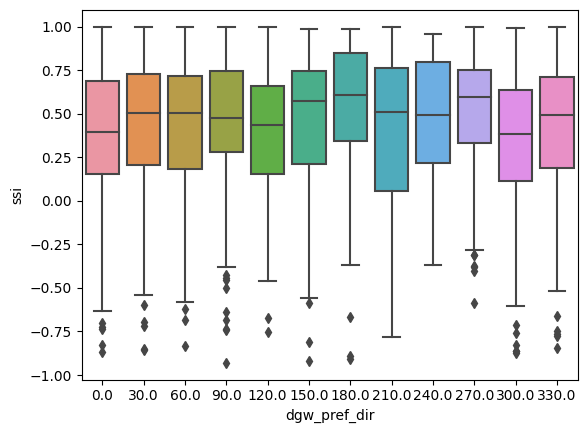

In [18]:
sns.boxplot(data=metrics[ss_inclusion], x="dgw_pref_dir", y="ssi")

<AxesSubplot:xlabel='dgw_lifetime_sparseness', ylabel='Count'>

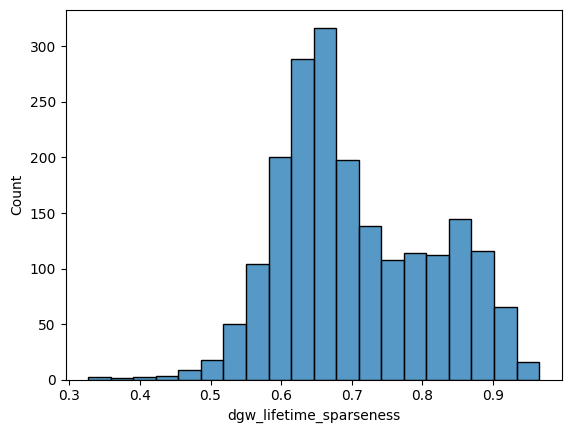

In [19]:
sns.histplot(metrics.dgw_lifetime_sparseness[ss_inclusion], bins=20)
# sns.histplot(metrics.dgf_lifetime_sparseness[ss_inclusion], bins=20)

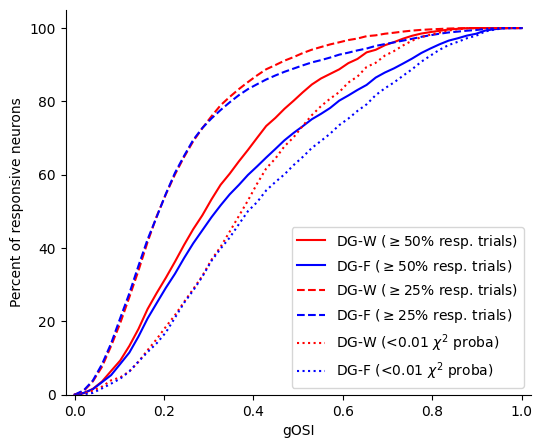

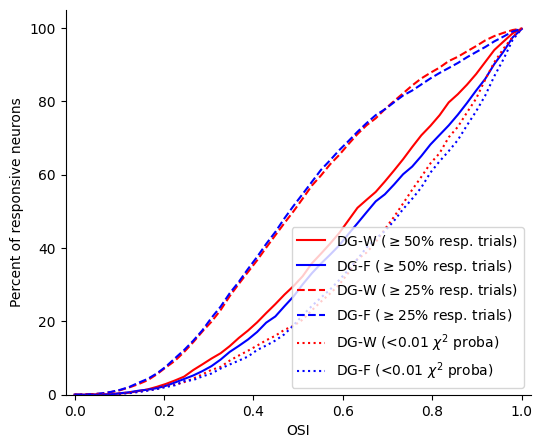

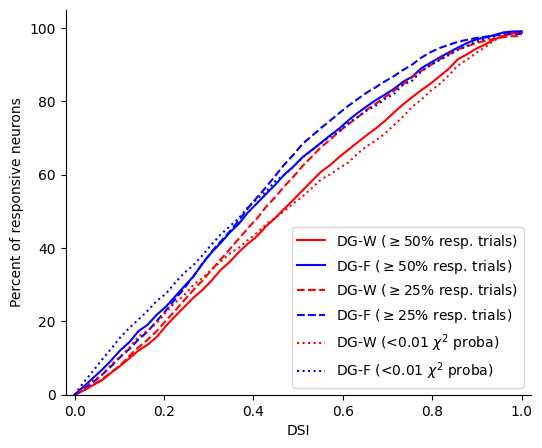

In [20]:
inclusion_criteria = [
    (r"$\geq 50$% resp. trials", lambda stim: metrics[f"{stim}_frac_responsive_trials"] >= 0.5),
    (r"$\geq 25$% resp. trials", lambda stim: metrics[f"{stim}_frac_responsive_trials"] >= 0.25),
    (r"<0.01 $\chi^2$ proba", lambda stim: metrics[f"{stim}_chisq_response_p"] < 0.01),
]

for metric_label, metric in (
    ("gOSI", "gosi"),
    ("OSI", "osi"),
    ("DSI", "dsi")
):
    fig, ax = plt.subplots(figsize=(6, 5), facecolor="white")
    x = np.linspace(0, 1)
    i = 0

    for inclusion_label, inclusion in inclusion_criteria:
        inclusion_w = inclusion("dgw")
        inclusion_f = inclusion("dgf")
        y_w = [np.mean(metrics[f"dgw_{metric}"][inclusion_w] < xx)*100 for xx in x]
        y_f = [np.mean(metrics[f"dgf_{metric}"][inclusion_f] < xx)*100 for xx in x]
        linestyle = ["solid", "dashed", "dotted"][i]
        ax.plot(x, y_w, color="red", linestyle=linestyle, label=f"DG-W ({inclusion_label})")
        ax.plot(x, y_f, color="blue", linestyle=linestyle, label=f"DG-F ({inclusion_label})")
        i += 1

    ax.legend(loc="lower right")
    ax.set_xlabel(metric_label)
    ax.set_ylabel("Percent of responsive neurons")
    ax.set_xlim(-0.02, 1.02)
    ax.set_ylim(0, 105)
    ax.spines[["top", "right"]].set_visible(False)

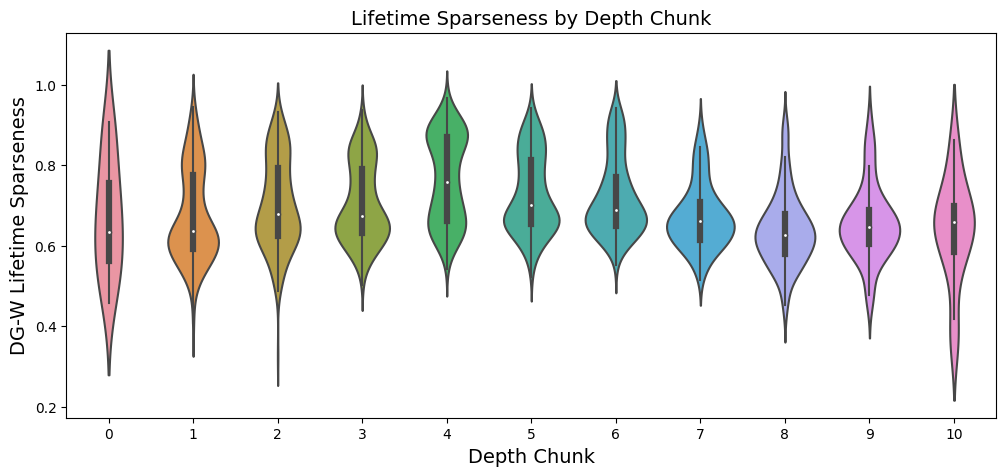

In [21]:
# Sparseness by depth
fig, ax = plt.subplots(figsize=(12, 5), facecolor="white")
sns.violinplot(data=metrics[ss_inclusion], x="depth_chunk", y="dgw_lifetime_sparseness")
ax.set_xlabel("Depth Chunk", fontsize=14)
ax.set_ylabel("DG-W Lifetime Sparseness", fontsize=14)
ax.set_title("Lifetime Sparseness by Depth Chunk", fontsize=14)
fig.savefig(f"{FIG_DIR}/sparseness_by_depth.png")

In [22]:
def vol_to_key(vol):
    try:
        vol = int(vol)
    except:
        pass

    if type(vol) is int and 1 <= vol <= 5:
        return f"Vol. {vol}"
    else:
        return "3P"

vol_key_to_color = {
    "Vol. 1": "red",
    "Vol. 2": "orange",
    "Vol. 3": "green",
    "Vol. 4": "blue",
    "Vol. 5": "purple",
    "3P": "pink"
}

legend_handles = [
    mpl.patches.Patch(facecolor=color, label=key)
    for key, color in vol_key_to_color.items()
]

In [23]:
metrics.dgf

AttributeError: 'DataFrame' object has no attribute 'dgf'

In [ ]:
def f(row):
    a, b = row.dgw_pref_response, row.dgf_resp_pref_dgw
    if b == 0:
        return np.NaN
    else:
        return a/b

metrics["suppression_strength"] = metrics.apply(f, axis=1)
metrics.suppression_strength.mean()

3.8467400143753028

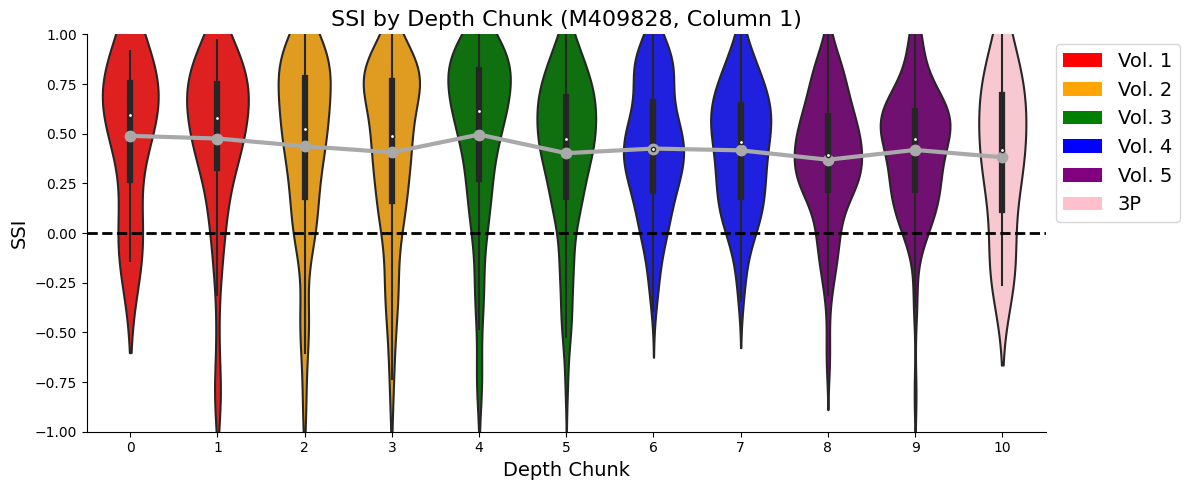

In [24]:
fig, ax = plt.subplots(figsize=(12, 5), facecolor="white")
volume_keys = [vol_to_key(metrics[metrics.depth_chunk == d].iloc[0].volume) for d in metrics[ss_inclusion].depth_chunk.unique()] # hacky way of getting volume for depth
colors = [vol_key_to_color[k] for k in volume_keys]

sns.violinplot(data=metrics[ss_inclusion], x="depth_chunk", y="ssi", ax=ax, palette=colors)
ax.legend(handles=legend_handles, loc="upper left", bbox_to_anchor=(1, 1), fontsize=14)
ax.set_xlim(-0.5, 10.5)
ax.set_ylim(-1, 1)
ax.set_xlabel("Depth Chunk", fontsize=14)
ax.set_ylabel("SSI", fontsize=14)
ax.set_title("SSI by Depth Chunk (M409828, Column 1)", fontsize=16)
means = metrics[ss_inclusion].groupby("depth_chunk").ssi.mean()
ax.plot(means.index, means.values, color="darkgray", linewidth=3, marker=".", markersize=15)
ax.axhline(y=0, color="black", linestyle="dashed", linewidth=2)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
fig.tight_layout()
# fig.savefig(f"{FIG_DIR}/ssi_by_depth_chunk.png")

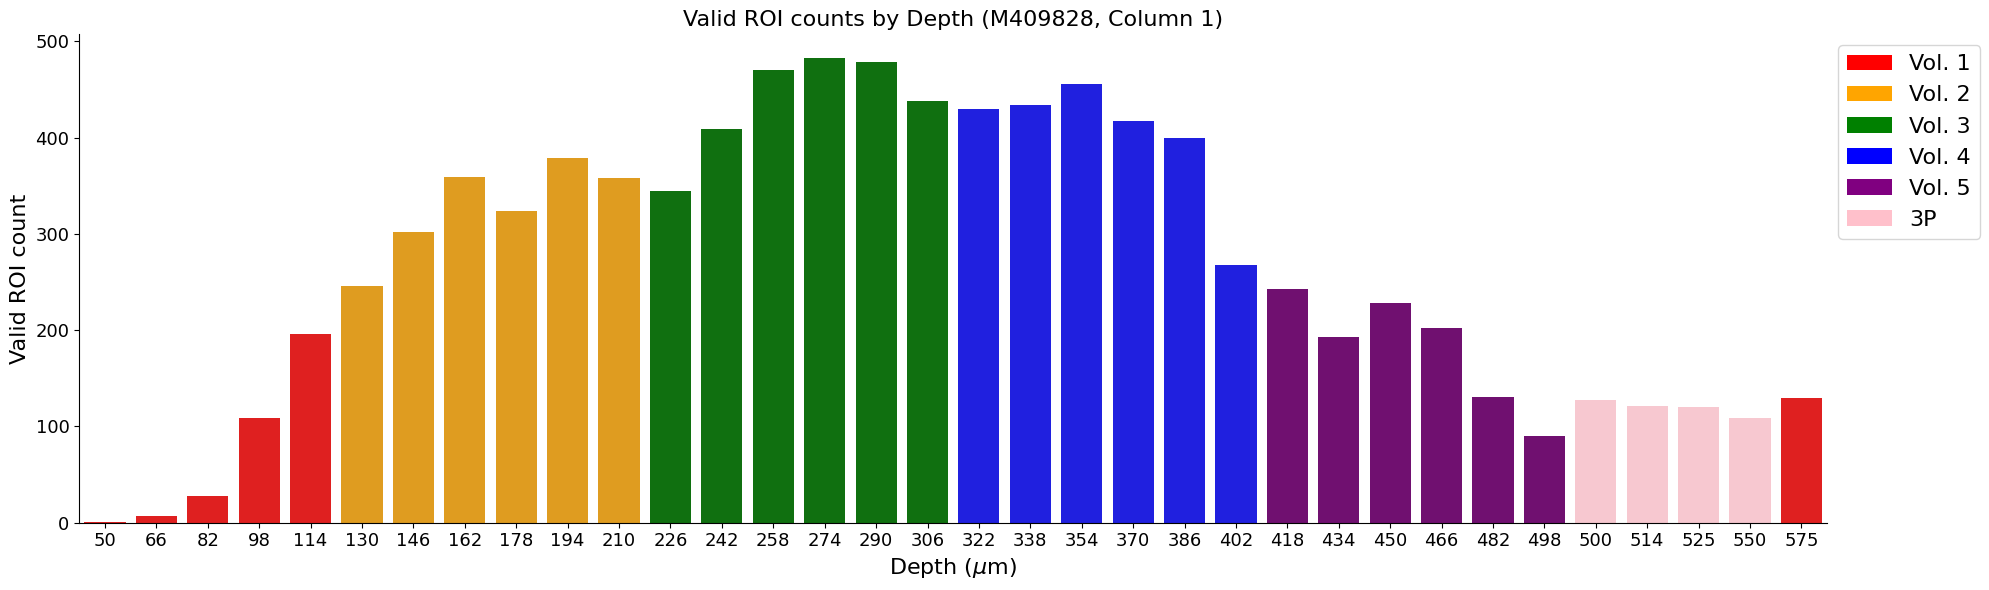

In [25]:
fig, ax = plt.subplots(figsize=(20, 6), facecolor="white")
volume_keys = [vol_to_key(metrics[metrics.depth == d].iloc[0].volume) for d in metrics[ss_inclusion].depth.unique()] # hacky way of getting volume for depth
colors = [vol_key_to_color[k] for k in volume_keys]

sns.countplot(x=metrics.depth, palette=colors, ax=ax)
ax.legend(handles=legend_handles, loc="upper left", bbox_to_anchor=(1, 1), fontsize=16)
ax.tick_params(labelsize=13)
ax.set_xlabel("Depth ($\mu$m)", fontsize=16)
ax.set_ylabel("Valid ROI count", fontsize=16)
ax.set_title("Valid ROI counts by Depth (M409828, Column 1)", fontsize=16)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
fig.tight_layout()
# fig.savefig(f"{FIG_DIR}/roi_count_by_depth.png")

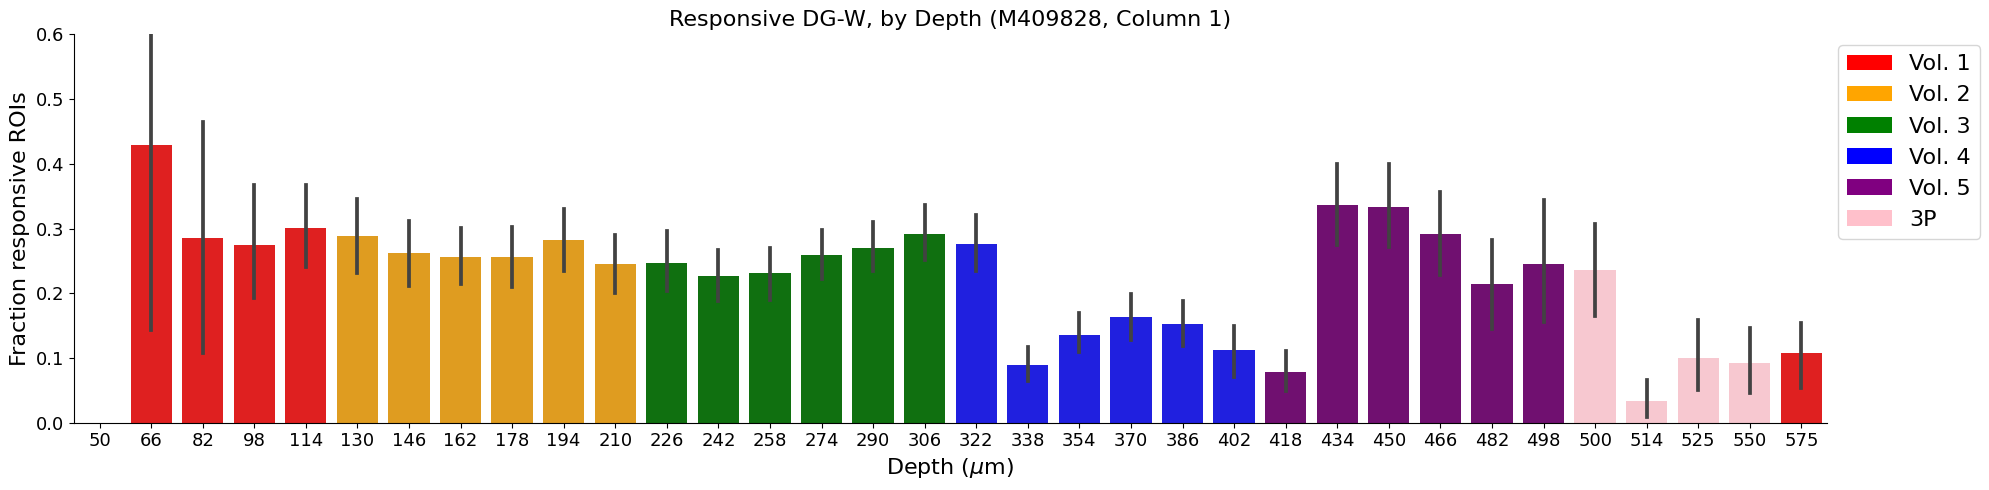

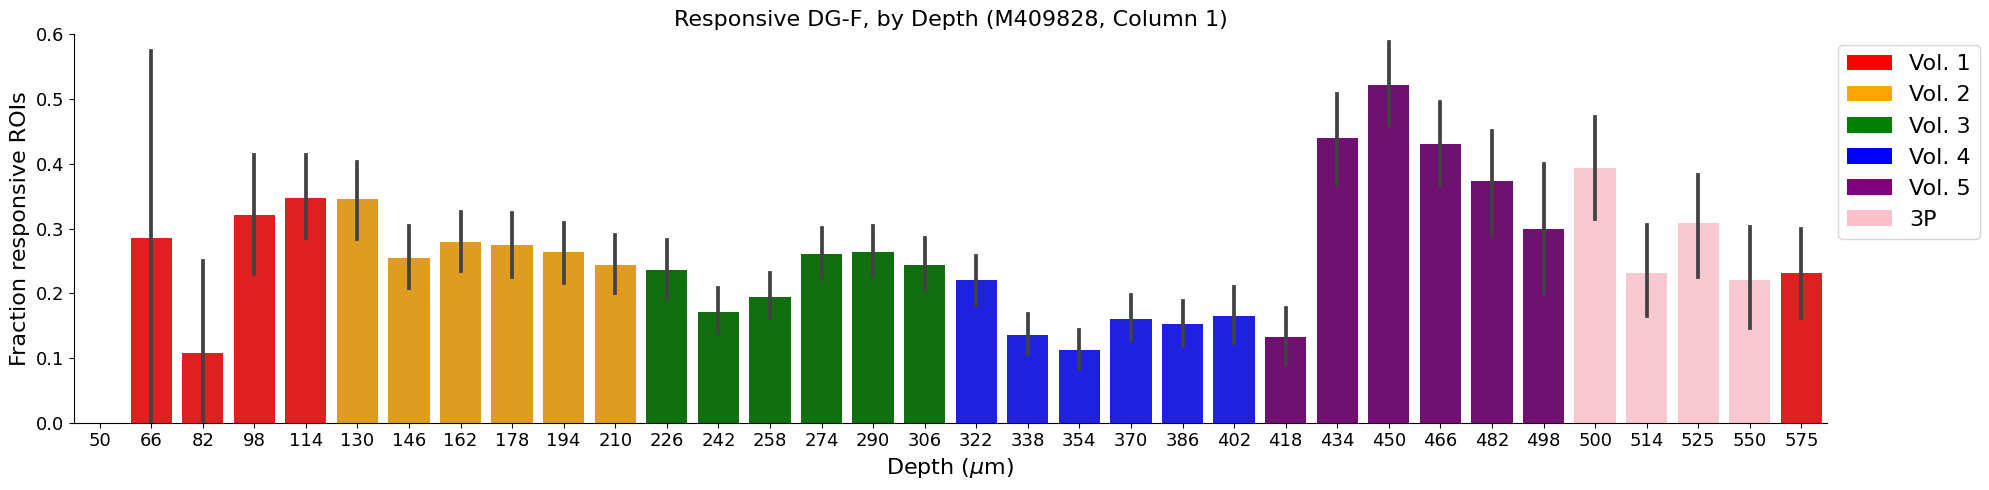

In [26]:
fig, ax = plt.subplots(figsize=(20, 5), facecolor="white")
volume_keys = [vol_to_key(metrics[metrics.depth == d].iloc[0].volume) for d in metrics[ss_inclusion].depth.unique()] # hacky way of getting volume for depth
colors = [vol_key_to_color[k] for k in volume_keys]

# sns.barplot(x=dg_full_metrics.depth, y=((dg_windowed_metrics.frac_responsive_trials_naive >= 0.25) | (dg_full_metrics.frac_responsive_trials_naive >= 0.25)), palette=colors, ax=ax)
sns.barplot(data=metrics, x="depth", y="dgw_is_responsive", palette=colors, ax=ax)
ax.legend(handles=legend_handles, loc="upper left", bbox_to_anchor=(1, 1), fontsize=16)
ax.set_ylim(0, 0.6)
ax.tick_params(labelsize=13)
ax.set_xlabel("Depth ($\mu$m)", fontsize=16)
ax.set_ylabel("Fraction responsive ROIs", fontsize=16)
ax.set_title("Responsive DG-W, by Depth (M409828, Column 1)", fontsize=16)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
fig.tight_layout()

fig, ax = plt.subplots(figsize=(20, 5), facecolor="white")
volume_keys = [vol_to_key(metrics[metrics.depth == d].iloc[0].volume) for d in metrics[ss_inclusion].depth.unique()] # hacky way of getting volume for depth
colors = [vol_key_to_color[k] for k in volume_keys]

# sns.barplot(x=dg_full_metrics.depth, y=((dg_windowed_metrics.frac_responsive_trials_naive >= 0.25) | (dg_full_metrics.frac_responsive_trials_naive >= 0.25)), palette=colors, ax=ax)
sns.barplot(data=metrics, x="depth", y="dgf_is_responsive", palette=colors, ax=ax)
ax.legend(handles=legend_handles, loc="upper left", bbox_to_anchor=(1, 1), fontsize=16)
ax.set_ylim(0, 0.6)
ax.tick_params(labelsize=13)
ax.set_xlabel("Depth ($\mu$m)", fontsize=16)
ax.set_ylabel("Fraction responsive ROIs", fontsize=16)
ax.set_title("Responsive DG-F, by Depth (M409828, Column 1)", fontsize=16)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
fig.tight_layout()
# fig.savefig(f"{FIG_DIR}/responsive_dg_by_depth.png")

In [27]:
metrics.columns

Index(['mouse', 'column', 'volume', 'plane', 'roi', 'is_valid', 'depth',
       'dgf_pref_response', 'dgf_pref_dir', 'dgf_pref_sf', 'dgf_pref_dir_idx',
       'dgf_pref_sf_idx', 'dgf_pref_dir_mean', 'dgf_z_score', 'dgf_response_p',
       'dgf_osi', 'dgf_gosi', 'dgf_dsi', 'dgf_frac_responsive_trials',
       'dgf_lifetime_sparseness', 'dgf_p_trial_responses',
       'dgf_sig_trial_responses', 'dgf_norm_dir_responses', 'dgf_pref_ori',
       'dgf_chisq_response_p', 'dgf_null_dist_multi_mean',
       'dgf_null_dist_multi_std', 'dgf_null_dist_single_mean',
       'dgf_null_dist_single_std', 'dgw_pref_response', 'dgw_pref_dir',
       'dgw_pref_sf', 'dgw_pref_dir_idx', 'dgw_pref_sf_idx',
       'dgw_pref_dir_mean', 'dgw_z_score', 'dgw_response_p', 'dgw_osi',
       'dgw_gosi', 'dgw_dsi', 'dgw_frac_responsive_trials',
       'dgw_lifetime_sparseness', 'dgw_p_trial_responses',
       'dgw_sig_trial_responses', 'dgw_norm_dir_responses', 'dgw_pref_ori',
       'dgw_chisq_response_p', 'dgw_null

Text(0.5, 1.0, 'Mean spontaneous null distribution for all valid ROIs')

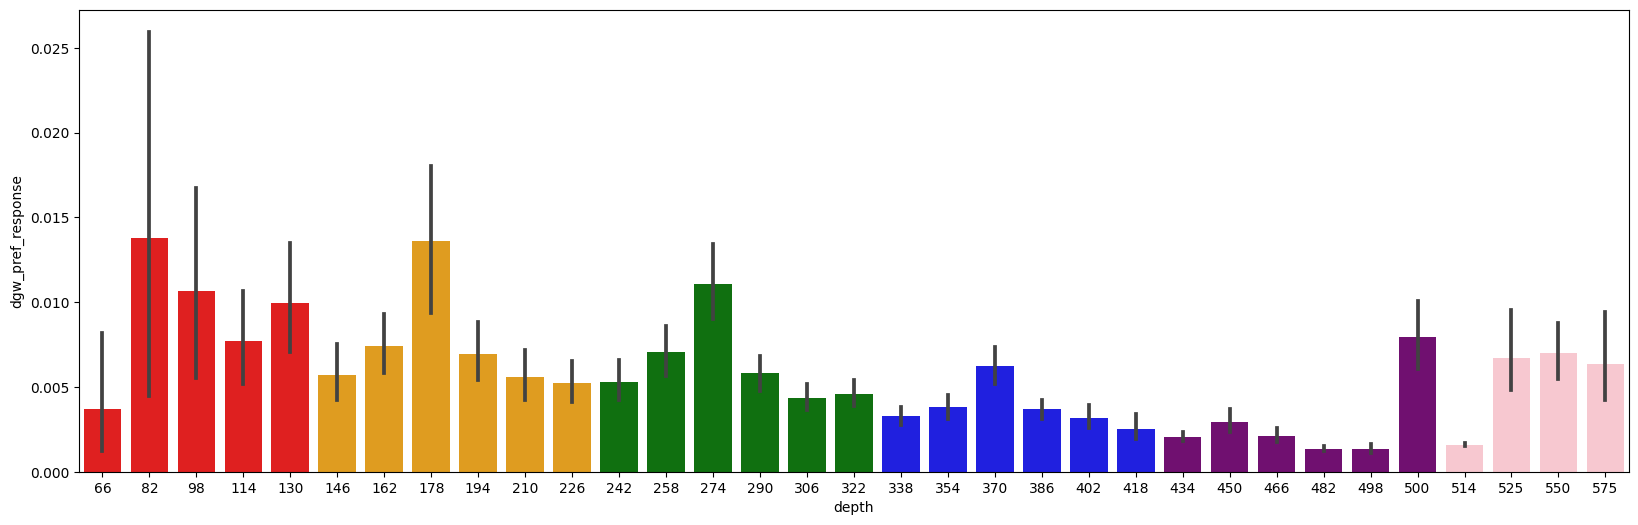

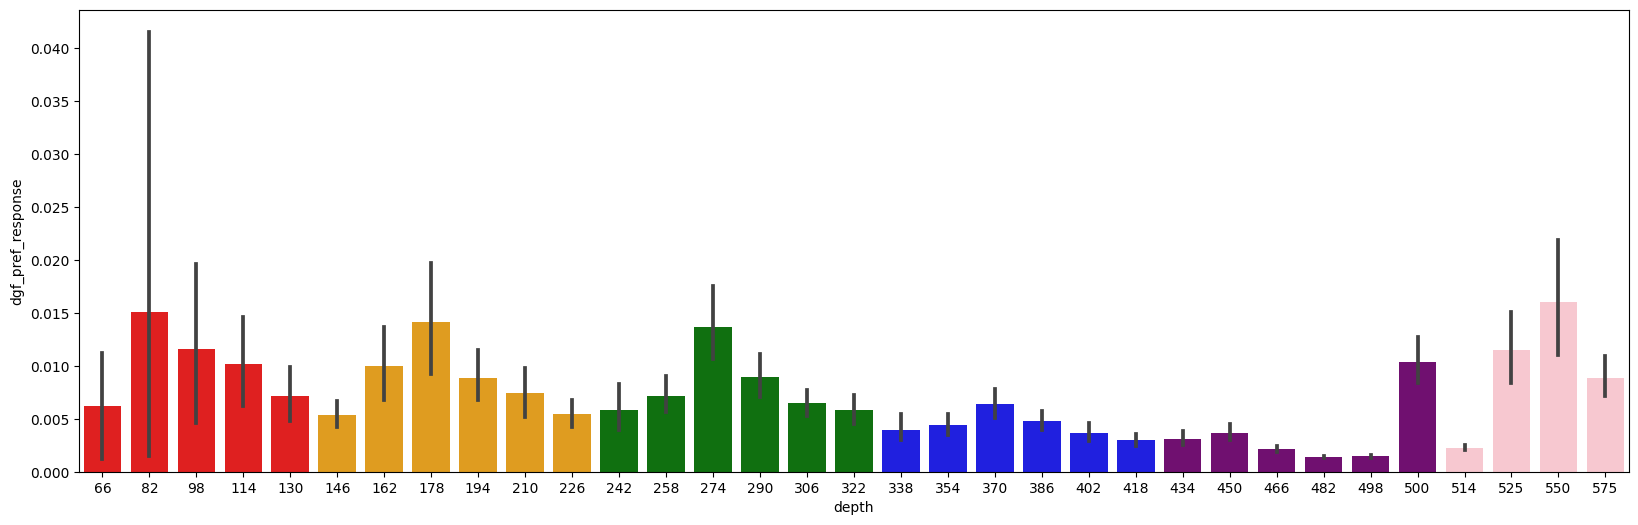

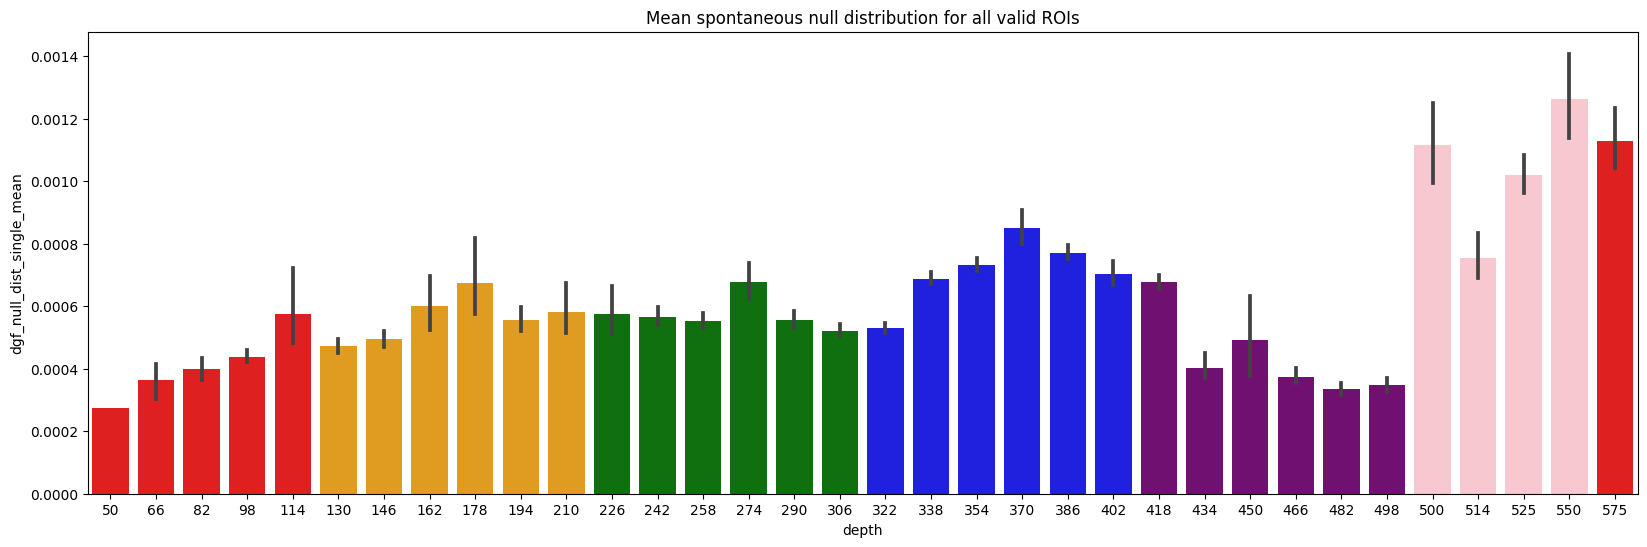

In [33]:
plt.figure(figsize=(20, 6))
sns.barplot(data=metrics[metrics.dgw_is_responsive], x="depth", y="dgw_pref_response", palette=colors)

plt.figure(figsize=(20, 6))
sns.barplot(data=metrics[metrics.dgf_is_responsive], x="depth", y="dgf_pref_response", palette=colors)

# plt.figure(figsize=(20, 6))
# sns.barplot(x=metrics[metrics.dgw_is_responsive]["depth"], y=metrics[metrics.dgw_is_responsive]["dgw_pref_response"] / metrics[metrics.dgw_is_responsive]["dgf_pref_response"], palette=colors)
# plt.ylim(0, 5)

plt.figure(figsize=(20, 6))
# sns.barplot(data=metrics, x="depth", y="dgf_null_dist_single_mean", palette=colors)
sns.barplot(data=metrics, x="depth", y="spontaneous_event_mean", palette=colors)
plt.title("Mean event during spontaneous stimulus, for all valid ROIs")

# plt.figure(figsize=(20, 6))
# sns.barplot(data=metrics[metrics.dgw_is_responsive], x="depth", y="spontaneous_event_mean", palette=colors)

# plt.figure(figsize=(20, 6))
# sns.barplot(data=metrics[metrics.dgf_is_responsive], x="depth", y="spontaneous_event_mean", palette=colors)
# metrics[metrics.dgw_is_responsive].groupby("depth")["dgw_pref_response"].median()

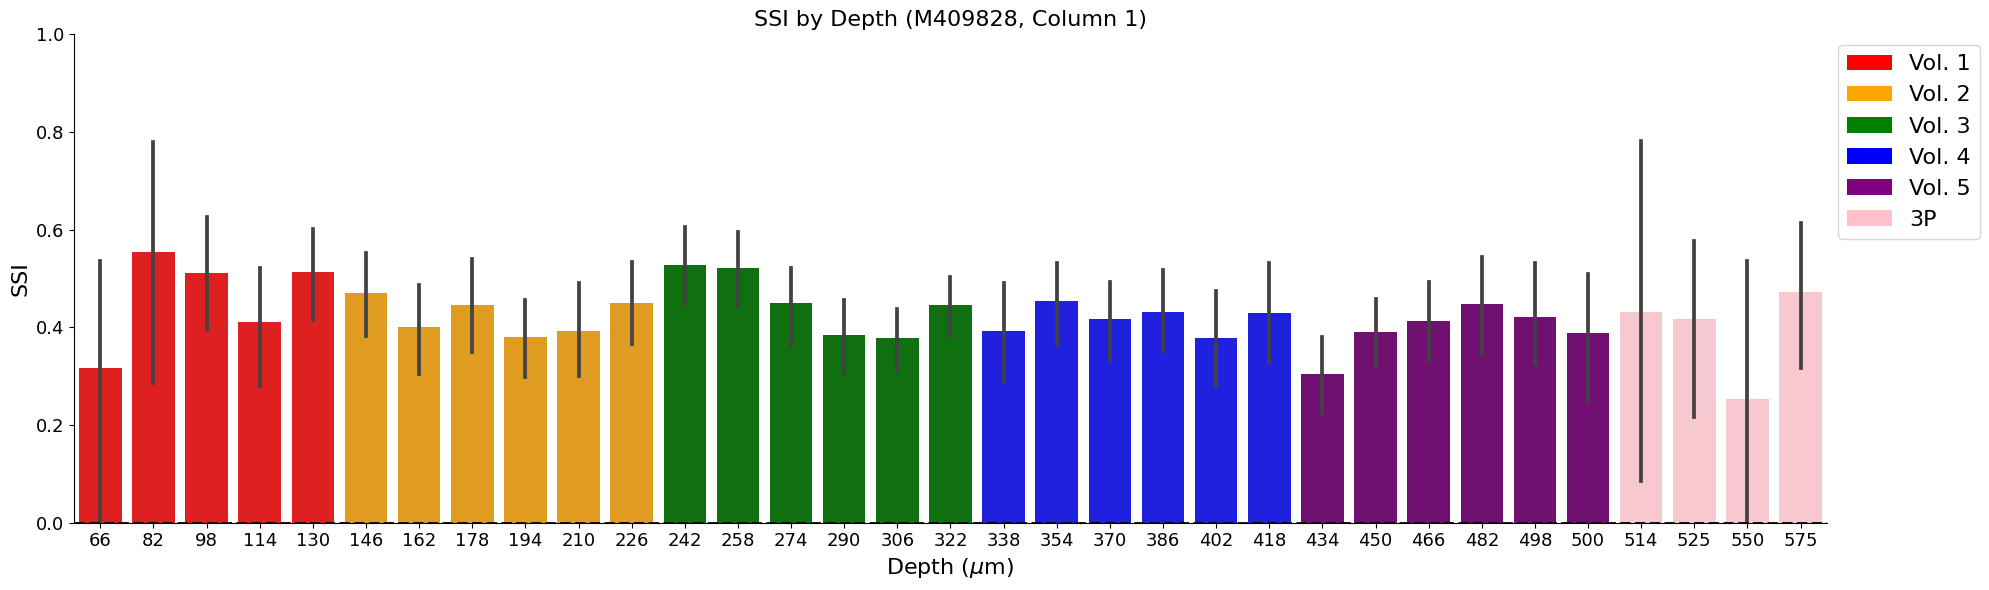

In [29]:
fig, ax = plt.subplots(figsize=(20, 6), facecolor="white")
volume_keys = [vol_to_key(metrics[metrics.depth == d].iloc[0].volume) for d in metrics[ss_inclusion].depth.unique()] # hacky way of getting volume for depth
colors = [vol_key_to_color[k] for k in volume_keys]

sns.barplot(data=metrics[ss_inclusion], x="depth", y="ssi", palette=colors, ax=ax)
ax.legend(handles=legend_handles, loc="upper left", bbox_to_anchor=(1, 1), fontsize=16)
# ax.set_ylim(-0.2, 0.6)
ax.set_ylim(0, 1)
ax.tick_params(labelsize=13)
ax.axhline(y=0, color="black", linestyle="dashed", linewidth=2)
ax.set_xlabel("Depth ($\mu$m)", fontsize=16)
ax.set_ylabel("SSI", fontsize=16)
ax.set_title("SSI by Depth (M409828, Column 1)", fontsize=16)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
fig.tight_layout()
# fig.savefig(f"{FIG_DIR}/ssi_mean_by_depth.png")

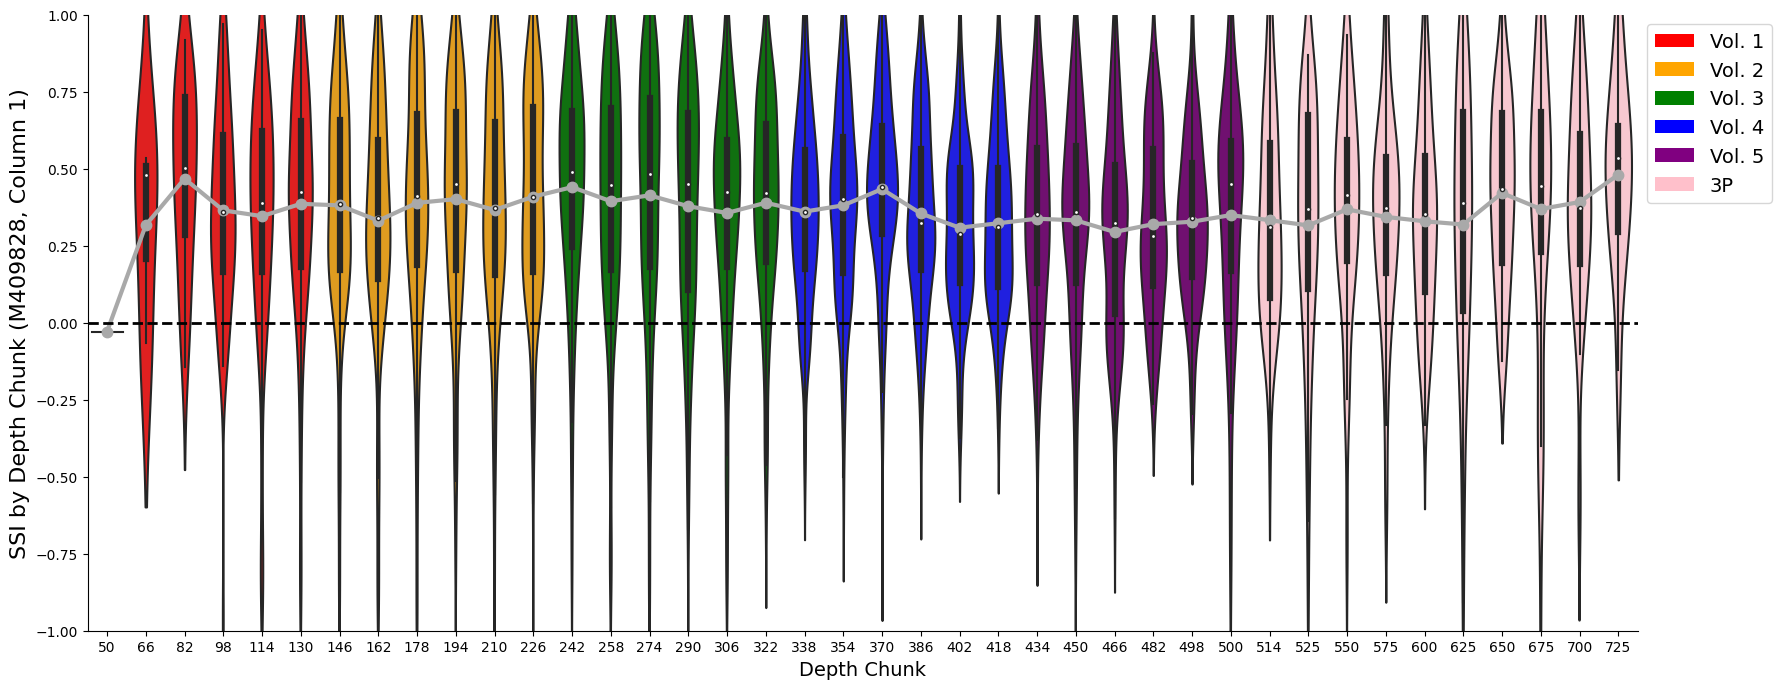

In [88]:
fig, ax = plt.subplots(figsize=(20, 8), facecolor="white")

sns.violinplot(data=ss_metrics[inclusion], x="depth", y="ssi", ax=ax, palette=colors)
ax.legend(handles=legend_handles, loc="upper left", bbox_to_anchor=(1, 1), fontsize=14)
ax.set_ylim(-1, 1)
ax.set_xlabel("Depth Chunk", fontsize=14)
ax.set_ylabel("SSI", fontsize=14)
ax.set_ylabel("SSI by Depth Chunk (M409828, Column 1)", fontsize=16)
means = ss_metrics[inclusion].groupby("depth").ssi.mean()
ax.plot(range(len(means.index)), means.values, color="darkgray", linewidth=3, marker=".", markersize=15)
ax.axhline(y=0, color="black", linestyle="dashed", linewidth=2)
ax.set_xlim(-0.5, len(means)-0.5)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

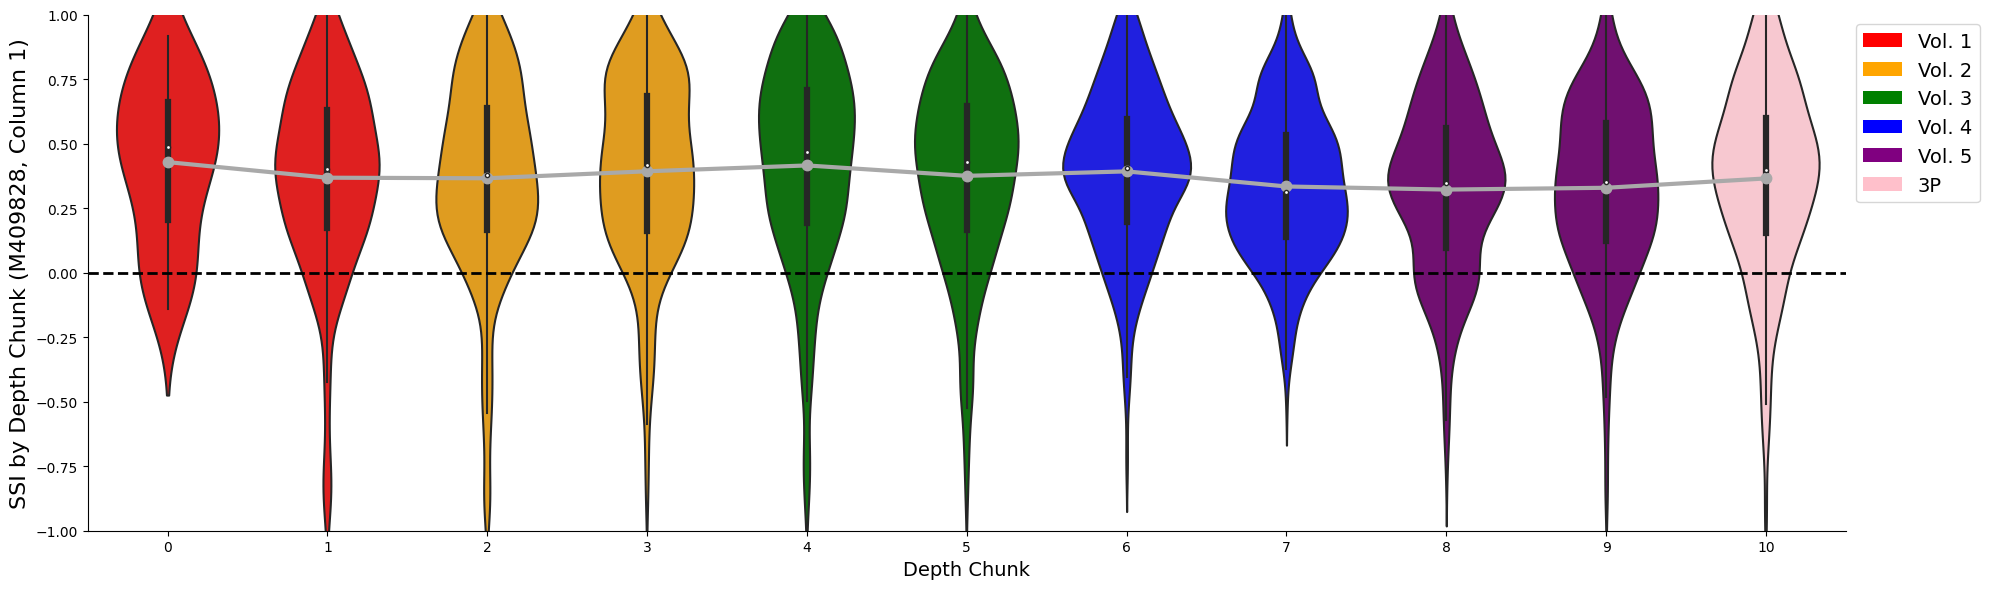

In [89]:
fig, ax = plt.subplots(figsize=(20, 6), facecolor="white")
volume_keys = [vol_to_key(ss_metrics[ss_metrics.depth_chunk == d].iloc[0].volume) for d in ss_metrics[inclusion].depth_chunk.unique()] # hacky way of getting volume for depth
colors = [vol_key_to_color[k] for k in volume_keys]

sns.violinplot(data=ss_metrics[inclusion], x="depth_chunk", y="ssi", ax=ax, palette=colors)
ax.legend(handles=legend_handles, loc="upper left", bbox_to_anchor=(1, 1), fontsize=14)
ax.set_xlim(-0.5, 10.5)
ax.set_ylim(-1, 1)
ax.set_xlabel("Depth Chunk", fontsize=14)
ax.set_ylabel("SSI", fontsize=14)
ax.set_ylabel("SSI by Depth Chunk (M409828, Column 1)", fontsize=16)
means = ss_metrics[inclusion].groupby("depth_chunk").ssi.mean()
ax.plot(means.index, means.values, color="darkgray", linewidth=3, marker=".", markersize=15)
ax.axhline(y=0, color="black", linestyle="dashed", linewidth=2)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
fig.tight_layout()
fig.savefig(f"{FIG_DIR}/ssi_by_depth_chunk.png")

(<Figure size 1000x800 with 2 Axes>,
 <AxesSubplot:title={'center':'Probabilities'}>)

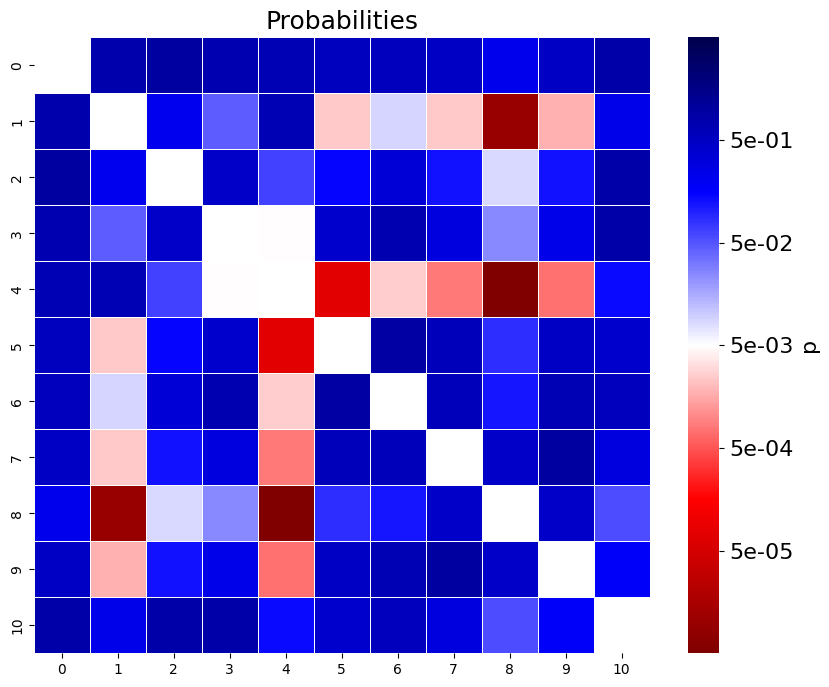

In [175]:
depth_chunks = ss_metrics.depth_chunk.unique()
n = len(depth_chunks)
p_matrix = np.zeros((n, n), dtype=float)

for i in range(n):
    p_matrix[i, i] = np.nan
    for j in range(i+1, n):
        x = ss_metrics.ssi[inclusion & (ss_metrics.depth_chunk == depth_chunks[i])]
        y = ss_metrics.ssi[inclusion & (ss_metrics.depth_chunk == depth_chunks[j])]
        _, p = st.ranksums(x, y)
        p_matrix[i, j] = p_matrix[j, i] = p

# at.heatmap_log_proba_plot(p_matrix, heatmap_labels=None, ticklabels=None, title="Probabilities", titlefontsize=18, xticklabelrotation=90, cbar_label="p", ax=None, ticklabelfontsize=16, figsize=(10, 8), significance_thresh=0.05, log=True, correct_comparisons=True)
at.heatmap_log_proba_plot(p_matrix)


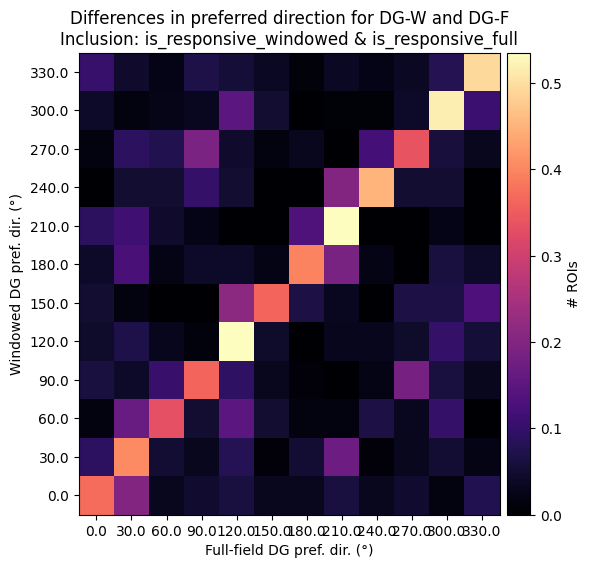

In [24]:
# Count cells that change preferred orientations
dir_list = sorted(metrics.dgw_pref_dir.unique())
n = len(dir_list)
pref_dir_w_vs_f = np.zeros((n, n))
inclusion = metrics.dgf_is_responsive & metrics.dgw_is_responsive
# inclusion = (dg_full_metrics["is_responsive"]) & (dg_windowed_metrics["is_responsive"])
# inclusion = (dg_windowed_metrics.is_responsive) & (dg_windowed_metrics.is_responsive)
# inclusion = (dg_windowed_metrics["is_responsive"]) & (dg_windowed_metrics["pref_ori_idx"] == dg_full_metrics["pref_ori_idx"])

for i in range(n):
    for j in range(n):
        count = np.count_nonzero(inclusion & (metrics["dgw_pref_dir_idx"] == i) & (metrics["dgf_pref_dir_idx"] == j))
        norm = np.count_nonzero(inclusion & (metrics["dgw_pref_dir_idx"] == i))
        pref_dir_w_vs_f[i, j] = count / norm

fig, ax = plt.subplots(figsize=(6.5, 6), facecolor="white")

vmin = 0
vmax = np.percentile(pref_dir_w_vs_f, 99)
cax = ax.pcolormesh(pref_dir_w_vs_f, cmap="magma", vmin=vmin, vmax=vmax)
cb = fig.colorbar(cax, pad=0.015, label="# ROIs")

ax.set_title("Differences in preferred direction for DG-W and DG-F\nInclusion: is_responsive_windowed & is_responsive_full")
ax.set_xlabel("Full-field DG pref. dir. (°)")
ax.set_ylabel("Windowed DG pref. dir. (°)")
ticks = [i+0.5 for i in range(len(dir_list))]
ax.set_xticks(ticks=ticks, labels=dir_list)
ax.set_yticks(ticks=ticks, labels=dir_list)

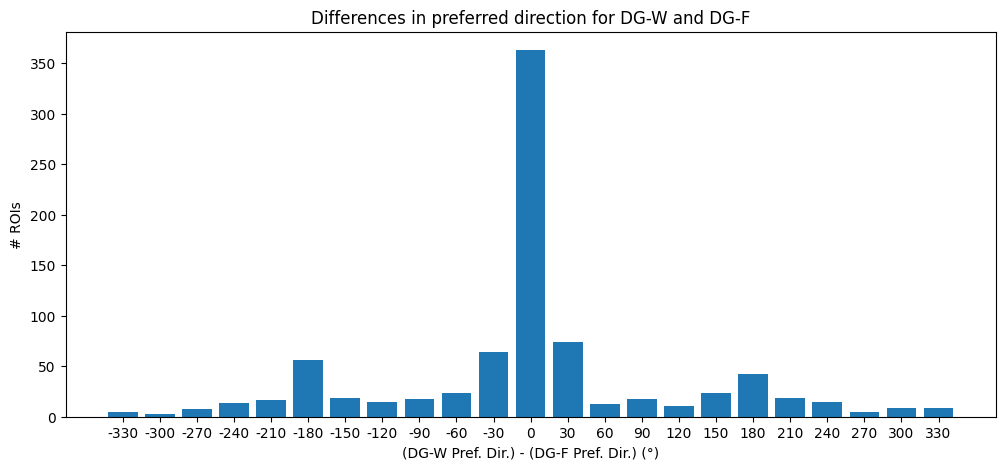

In [26]:
# Histogram of delta dir pref. across ROIs
fig, ax = plt.subplots(figsize=(12, 5), facecolor="white")
roi_delta_dir = (metrics["dgw_pref_dir"] - metrics["dgf_pref_dir"])[inclusion].values

delta_dir = sorted(np.unique(roi_delta_dir))
counts = [np.count_nonzero(roi_delta_dir == x) for x in delta_dir]
ax.bar([f"{d:.0f}" for d in delta_dir], counts)
ax.set_xlabel("(DG-W Pref. Dir.) - (DG-F Pref. Dir.) (°)")
ax.set_ylabel("# ROIs")
ax.set_title("Differences in preferred direction for DG-W and DG-F")
fig.savefig(f"{FIG_DIR}/diff_pref_dir.png")

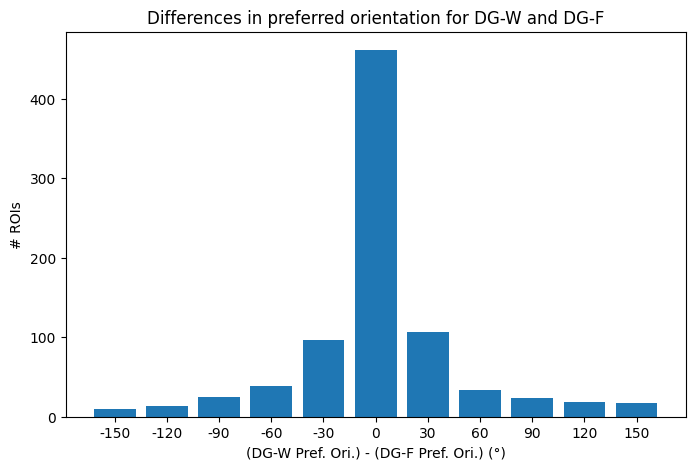

In [28]:
# Histogram of delta ori pref. across ROIs
fig, ax = plt.subplots(figsize=(8, 5), facecolor="white")
roi_delta_ori = (metrics["dgw_pref_ori"] - metrics["dgf_pref_ori"])[inclusion].values
delta_ori = sorted(np.unique(roi_delta_ori))

counts = [np.count_nonzero(roi_delta_ori == x) for x in delta_ori]
ax.bar([f"{d:.0f}" for d in delta_ori], counts)
ax.set_xlabel("(DG-W Pref. Ori.) - (DG-F Pref. Ori.) (°)")
ax.set_ylabel("# ROIs")
ax.set_title("Differences in preferred orientation for DG-W and DG-F")
fig.savefig(f"{FIG_DIR}/diff_pref_ori.png")